In [1]:
# LIBRARY IMPORTS
# Standard library imports
import os  # For file and directory operations
import pickle  # For saving/loading Python objects (models, scalers, etc.)
import warnings  # For suppressing warnings during execution
warnings.filterwarnings('ignore')  # Ignore warnings to keep output clean

# Audio processing libraries
import librosa  # Main library for audio file loading and audio feature extraction
import numpy as np  # Numerical computing library for array operations
from scipy.signal import butter, filtfilt  # Signal processing for bandpass filtering

# Data manipulation and analysis
import pandas as pd  # Data manipulation and Excel file creation

# Machine learning libraries - Traditional ML models
from sklearn.model_selection import train_test_split  # For splitting data into train/validation/test sets
from sklearn.preprocessing import LabelEncoder, StandardScaler  # For encoding labels and scaling features
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier (if needed)
from sklearn.metrics import (  # Evaluation metrics
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report)

# Deep learning libraries - TensorFlow/Keras
from tensorflow.keras.utils import to_categorical  # Convert labels to one-hot encoding
from tensorflow.keras.models import Sequential, load_model  # Model architecture and loading
from tensorflow.keras.layers import (  # Neural network layers
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional)
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Training callbacks

# Visualization libraries
import matplotlib.pyplot as plt  # For creating plots and figures
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg  # For embedding plots in GUI
from matplotlib.figure import Figure  # For creating figure objects

# Audio playback (for Jupyter notebook)
from IPython.display import Audio, display  # For playing audio samples in notebook

# GUI libraries
import tkinter as tk  # For creating graphical user interface
from tkinter import filedialog, messagebox  # For file dialogs and message boxes

# Image processing
from skimage.transform import resize  # For resizing images (for CNN input)

In [2]:
# CONFIGURATION
FOLDER_PATH = r"C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2"
CLASSES = ['Bronchial', 'copd', 'healthy', 'pneumonia', 'asthma']
TARGET_SR = 22050
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Sample audio files for demonstration
SAMPLE_AUDIO_FILES = [
    r"C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2\Bronchial\P7BronchialSc_32.wav",
    r"C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2\asthma\P7AsthmaIE_33.wav",
    r"C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2\copd\P5COPDMc_34.wav",
    r"C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2\healthy\P7Healthy85S.wav",
    r"C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2\pneumonia\P6Pneumonia39O.wav"
]

# Function for removing Nan/Inf values from the audio signal
def clean_nan_inf(audio):
    cleaned = audio.copy()
    nan_inf_mask = np.isnan(cleaned) | np.isinf(cleaned)
    if np.any(nan_inf_mask):
        cleaned[nan_inf_mask] = 0.0
    return cleaned

# Function for Normalizing band edges for filtering
def normalize_band_edges(lowcut, highcut, fs):
    nyquist = 0.5 * fs
    if nyquist <= 0:
        raise ValueError("Sampling rate must be positive")
    
    epsilon = 1e-6
    adj_low = max(lowcut, epsilon)
    adj_high = min(highcut, nyquist - epsilon)
    
    if adj_low >= adj_high:
        adj_low = max(epsilon, adj_high * 0.5)
    
    low = adj_low / nyquist
    high = adj_high / nyquist
    return low, high

# Function for Adding white noise to audio with specified Signal-to-Noise Ratio
def add_noise_snr(audio, snr_db=20):
    try:
        # Calculate signal power
        signal_power = np.mean(audio ** 2)
        
        # Avoid log of zero or negative values
        if signal_power < 1e-10:
            print("Warning: Signal power too low, returning original audio")
            return audio
        
        # Calculate noise power based on desired SNR
        # SNR(dB) = 10 * log10(signal_power / noise_power)
        # noise_power = signal_power / (10^(SNR/10))
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        
        # Generate white noise with calculated power
        noise = np.random.randn(len(audio)) * np.sqrt(noise_power)
        
        # Add noise to signal
        noisy_audio = audio + noise
        
        # Clip to prevent overflow
        noisy_audio = np.clip(noisy_audio, -1.0, 1.0)
        
        # Clean any NaN/Inf values
        noisy_audio = clean_nan_inf(noisy_audio)
        
        return noisy_audio
    
    except Exception as e:
        print(f"Warning: add_noise_snr failed: {e}")
        return audio

# DATA LOADING
def load_audio_files(data_path, classes, target_sr=TARGET_SR):
    audio_data = []
    labels = []
    
    print(f"Loading audio files from {data_path}...")
    
    for label in classes:
        folder_path = os.path.join(data_path, label)
        if not os.path.isdir(folder_path):
            print(f"Warning: Class folder missing -> {folder_path}")
            continue
        
        for filename in os.listdir(folder_path):
            if filename.lower().endswith('.wav'):
                file_path = os.path.join(folder_path, filename)
                try:
                    audio, sr = librosa.load(file_path, sr=target_sr)
                    audio = clean_nan_inf(audio)
                    audio_data.append({
                        'audio': audio,
                        'sr': sr,
                        'label': label,
                        'filename': filename
                    })
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue
    
    print(f"Loaded {len(audio_data)} audio files")
    
    # Play sample audio files
    play_sample_audio_files()
    
    return audio_data, labels


In [3]:

# Function for playing sample audio files
def play_sample_audio_files(num_samples=5):
    print(f"\n{'*'*40}")
    print("Playing Sample Audio Files")
    print(f"{'*'*40}")
    
    played_count = 0
    for file_path in SAMPLE_AUDIO_FILES:
        if played_count >= num_samples:
            break
        
        if os.path.exists(file_path):
            try:
                audio, sr = librosa.load(file_path, sr=TARGET_SR)
                filename = os.path.basename(file_path)
                label = os.path.basename(os.path.dirname(file_path))
                print(f"\nPlaying: {label}/{filename}")
                display(Audio(data=audio, rate=sr))
                played_count += 1
            except Exception as e:
                print(f"Error playing {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")



In [4]:

#####

# DATA AUGMENTATION
# This codes implements data augmentation for increasing the size of the dataset
def augment_single_audio(audio, sr):
    # Validate and clean input
    if len(audio) == 0:
        print("Warning: Empty audio received")
        return [audio]
    
    audio = clean_nan_inf(audio)
    augmented = []
    
    # 1. Original audio
    augmented.append(audio.copy())
    
    # 2. Gain scaling (0.9 to 1.1)
    try:
        gain = np.random.uniform(0.9, 1.1)
        gained = audio * gain
        gained = np.clip(gained, -1.0, 1.0)  # Prevent overflow
        gained = clean_nan_inf(gained)
        augmented.append(gained)
    except Exception as e:
        print(f"Warning: Gain scaling failed: {e}")
    
    # 3. Time shift (≤100 ms) to avoid wrap-around artifacts
    try:
        max_shift_samples = int(0.1 * sr)  # 100 ms
        
        # Only shift if audio is long enough
        if len(audio) > max_shift_samples * 2:
            shift = int(np.random.uniform(-max_shift_samples, max_shift_samples))
            
            # Use zero-padding instead of np.roll to avoid wrap-around
            if shift > 0:
                # Shift right (delay) - pad at start, trim at end
                shifted = np.pad(audio[:-shift], (shift, 0), mode='constant')
            elif shift < 0:
                # Shift left (advance) - trim at start, pad at end
                shifted = np.pad(audio[-shift:], (0, -shift), mode='constant')
            else:
                shifted = audio.copy()
            
            shifted = clean_nan_inf(shifted)
            augmented.append(shifted)
        else:
            # Audio too short, just add original again
            print(f"Warning: Audio too short for time shift ({len(audio)} samples)")
            augmented.append(audio.copy())
    except Exception as e:
        print(f"Warning: Time shift failed: {e}")
        augmented.append(audio.copy())
    
    # 4. Add noise (SNR-based: 15-30 dB)
    try:
        snr_db = np.random.uniform(15, 30)
        noisy = add_noise_snr(audio, snr_db=snr_db)
        noisy = clean_nan_inf(noisy)
        augmented.append(noisy)
    except Exception as e:
        print(f"Warning: Noise addition failed: {e}")
        augmented.append(audio.copy())
    
    return augmented

# Function for plotting the raw and augmentated data
def plot_raw_and_augmented(audio_data, num_samples=5):
    print(f"\n{'*'*40}")
    print("Plotting Raw and Augmented Audio")
    print(f"{'*'*40}")
    
    num_samples = min(num_samples, len(audio_data))
    
    for idx, item in enumerate(audio_data[:num_samples]):
        try:
            audio = item['audio']
            sr = item['sr']
            label = item['label']
            filename = item['filename']
            
            # Validate audio
            if len(audio) == 0:
                print(f"Skipping empty audio: {filename}")
                continue
            
            # Clean audio
            audio = clean_nan_inf(audio)
            
            # Generate augmented versions
            augmented_audios = augment_single_audio(audio, sr)
            
            # Create figure
            fig, axes = plt.subplots(len(augmented_audios), 1, 
                                    figsize=(12, 3*len(augmented_audios)))
            
            # Handle single subplot case
            if len(augmented_audios) == 1:
                axes = [axes]
            
            # Augmentation labels
            aug_labels = ['Original', 'Gain Scaled', 'Time Shifted', 'Noise Added']
            
            # Plot each augmentation
            for i, aud in enumerate(augmented_audios):
                time_axis = np.arange(len(aud)) / sr
                axes[i].plot(time_axis, aud, color='steelblue', linewidth=0.5)
                
                # Get augmentation label
                title = aug_labels[i] if i < len(aug_labels) else f"Augmented {i}"
                axes[i].set_title(f"{title} - {label}/{filename}", 
                                fontsize=12, fontweight='bold')
                axes[i].set_xlabel("Time (s)", fontsize=10)
                axes[i].set_ylabel("Amplitude", fontsize=10)
                axes[i].grid(True, alpha=0.3)
                axes[i].set_xlim([0, time_axis[-1]])
                
                # Add statistics
                max_amp = np.max(np.abs(aud))
                rms = np.sqrt(np.mean(aud**2))
                stats_text = f"Max: {max_amp:.3f} | RMS: {rms:.3f}"
                axes[i].text(0.02, 0.98, stats_text, 
                           transform=axes[i].transAxes,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                           fontsize=8)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Plotted sample {idx+1}/{num_samples}: {filename}")
            
        except Exception as e:
            print(f"Error plotting sample {idx}: {e}")
            import traceback
            traceback.print_exc()
    
    print(f"{'*'*40}\n")


In [5]:
######## Filtering or removing noise from the sounds
# Apply Butterworth bandpass filter with zero-phase (filtfilt)
def apply_bandpass_filter(audio, lowcut=20, highcut=2000, fs=22050, order=5):
    try:
        # Clamp order to valid range
        if order < 4:
            order = 4
        elif order > 6:
            order = 6
        
        # Normalize band edges
        low, high = normalize_band_edges(lowcut, highcut, fs)
        
        # Butterworth bandpass filter
        b, a = butter(order, [low, high], btype='band')
        
        # Apply zero-phase filtering
        filtered_data = filtfilt(b, a, audio)
        
        # Clean any NaN/Inf values
        filtered_data = clean_nan_inf(filtered_data)
        
        return filtered_data
    
    except Exception as e:
        print(f"Warning: Bandpass filter failed: {e}")
        return audio

# Apply bandpass filter to all audio files
def filter_audio_data(audio_data, lowcut=20, highcut=2000):
    print(f"\n{'*'*40}")
    print(f"Filtering audio data ({lowcut}-{highcut} Hz)...")
    print(f"{'*'*40}")
    
    filtered_data = []
    failed_count = 0
    
    for idx, item in enumerate(audio_data):
        try:
            # Validate item
            if 'audio' not in item or 'sr' not in item:
                print(f"Warning: Invalid item at index {idx}")
                failed_count += 1
                continue
            
            # Apply bandpass filter
            filtered_audio = apply_bandpass_filter(
                item['audio'], 
                lowcut=lowcut, 
                highcut=highcut, 
                fs=item['sr']
            )
            
            # Clean filtered audio
            filtered_audio = clean_nan_inf(filtered_audio)
            
            # Store filtered data
            filtered_data.append({
                'audio': filtered_audio,
                'sr': item['sr'],
                'label': item.get('label', 'unknown'),
                'filename': item.get('filename', f'unknown_{idx}'),
                'augmentation_type': item.get('augmentation_type', 'unknown')
            })
            
            # Progress indicator
            if (idx + 1) % 500 == 0:
                print(f"Filtered {idx + 1}/{len(audio_data)} samples...")
        
        except Exception as e:
            print(f"Error filtering item {idx}: {e}")
            failed_count += 1
    
    print(f"\nFiltered {len(filtered_data)} audio files")
    print(f"Failed: {failed_count}")
    print(f"{'*'*40}\n")
    
    return filtered_data

def plot_raw_augmented_filtered(audio_data, num_samples=5, lowcut=20, highcut=2000):
    print(f"\n{'*'*40}")
    print("Plotting Raw, Augmented, and Filtered Audio")
    print(f"{'*'*40}")
    
    num_samples = min(num_samples, len(audio_data))
    
    for idx, item in enumerate(audio_data[:num_samples]):
        try:
            audio = item['audio']
            sr = item['sr']
            label = item['label']
            filename = item['filename']
            
            # Validate audio
            if len(audio) == 0:
                print(f"Skipping empty audio: {filename}")
                continue
            
            # Clean audio
            audio = clean_nan_inf(audio)
            
            # Generate augmented version (using gain as example)
            gain = 1.05
            augmented_audio = audio * gain
            augmented_audio = np.clip(augmented_audio, -1.0, 1.0)
            augmented_audio = clean_nan_inf(augmented_audio)
            
            # Apply bandpass filter to augmented audio
            filtered_audio = apply_bandpass_filter(augmented_audio, lowcut, highcut, sr)
            
            # Create figure with 3 rows
            fig, axes = plt.subplots(3, 1, figsize=(14, 10))
            
            time_axis = np.arange(len(audio)) / sr
            
            # RAW AUDIO
            axes[0].plot(time_axis, audio, color='steelblue', linewidth=0.5)
            axes[0].set_title(f'Raw Audio - {label}/{filename}', 
                            fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Time (s)', fontsize=10)
            axes[0].set_ylabel('Amplitude', fontsize=10)
            axes[0].grid(True, alpha=0.3)
            axes[0].set_xlim([0, time_axis[-1]])
            axes[0].set_ylim([-1.1, 1.1])
            
            # Add statistics
            max_amp = np.max(np.abs(audio))
            rms = np.sqrt(np.mean(audio**2))
            axes[0].text(0.02, 0.98, f"Max: {max_amp:.3f} | RMS: {rms:.3f}", 
                        transform=axes[0].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
                        fontsize=9)
            
            # AUGMENTED AUDIO
            axes[1].plot(time_axis, augmented_audio, color='orange', linewidth=0.5)
            axes[1].set_title(f'Augmented Audio (Gain: {gain}x)', 
                            fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Time (s)', fontsize=10)
            axes[1].set_ylabel('Amplitude', fontsize=10)
            axes[1].grid(True, alpha=0.3)
            axes[1].set_xlim([0, time_axis[-1]])
            axes[1].set_ylim([-1.1, 1.1])
            
            # Add statistics
            max_amp_aug = np.max(np.abs(augmented_audio))
            rms_aug = np.sqrt(np.mean(augmented_audio**2))
            axes[1].text(0.02, 0.98, f"Max: {max_amp_aug:.3f} | RMS: {rms_aug:.3f}", 
                        transform=axes[1].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                        fontsize=9)
            
            # FILTERED AUDIO
            axes[2].plot(time_axis, filtered_audio, color='green', linewidth=0.5)
            axes[2].set_title(f'Filtered Audio ({lowcut}-{highcut} Hz)', 
                            fontsize=12, fontweight='bold')
            axes[2].set_xlabel('Time (s)', fontsize=10)
            axes[2].set_ylabel('Amplitude', fontsize=10)
            axes[2].grid(True, alpha=0.3)
            axes[2].set_xlim([0, time_axis[-1]])
            axes[2].set_ylim([-1.1, 1.1])
            
            # Add statistics
            max_amp_filt = np.max(np.abs(filtered_audio))
            rms_filt = np.sqrt(np.mean(filtered_audio**2))
            axes[2].text(0.02, 0.98, f"Max: {max_amp_filt:.3f} | RMS: {rms_filt:.3f} | Filter: {lowcut}-{highcut} Hz", 
                        transform=axes[2].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                        fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Plotted sample {idx+1}/{num_samples}: {filename}")
            
        except Exception as e:
            print(f"Error plotting sample {idx}: {e}")
            import traceback
            traceback.print_exc()
    
    print(f"{'*'*40}\n")



In [6]:

# Apply augmentation to entire dataset
def augment_full_dataset(audio_data):
    print("\n" + "*"*40)
    print("APPLYING AUGMENTATION TO FULL DATASET")
    print("*"*40)
    
    augmented_data = []
    failed_count = 0
    
    for idx, item in enumerate(audio_data):
        try:
            # Validate item
            if 'audio' not in item or 'sr' not in item:
                print(f"Warning: Invalid item at index {idx}")
                failed_count += 1
                continue
            
            # Generate augmented versions
            augmented_audios = augment_single_audio(item['audio'], item['sr'])
            aug_types = ['original', 'gain', 'shift', 'noise']
            
            # Add each augmentation to dataset
            for aug_idx, aug_audio in enumerate(augmented_audios):
                augmented_data.append({
                    'audio': aug_audio,
                    'sr': item['sr'],
                    'label': item['label'],
                    'filename': item.get('filename', f'unknown_{idx}'),
                    'augmentation_type': aug_types[aug_idx] if aug_idx < len(aug_types) else f'aug_{aug_idx}'
                })
            
            # Progress indicator
            if (idx + 1) % 100 == 0:
                print(f"Augmented {idx + 1}/{len(audio_data)} samples...")
        
        except Exception as e:
            print(f"Error augmenting sample {idx}: {e}")
            failed_count += 1
    
    print(f"\nAugmentation complete!")
    print(f"Original samples: {len(audio_data)}")
    print(f"Augmented samples: {len(augmented_data)}")
    print(f"Augmentation factor: {len(augmented_data)/len(audio_data):.2f}x")
    print(f"Failed samples: {failed_count}")
    print("*"*60 + "\n")
    
    return augmented_data



In [7]:
# FEATURE EXTRACTION FOR LUNG SOUND CLASSIFICATION

# Extract MFCC-based audio features by computing MFCCs and their temporal dynamics.
# Returns the mean and standard deviation of MFCCs over time, along with the mean
# first- and second-order delta coefficients to capture spectral changes.
def extract_mfcc_features(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512):

    try:
        # Clean audio
        audio = clean_nan_inf(audio)
        
        if len(audio) < n_fft:
            # Pad audio if too short
            audio = np.pad(audio, (0, n_fft - len(audio)), mode='constant')
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, 
                                     n_fft=n_fft, hop_length=hop_length)
        
        # Calculate statistics
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_std = np.std(mfccs, axis=1)
        
        # Calculate first and second order derivatives (delta and delta-delta)
        mfcc_delta = librosa.feature.delta(mfccs)
        mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
        
        mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
        mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)
        
        # Replace any NaN/Inf values
        mfcc_mean = clean_nan_inf(mfcc_mean)
        mfcc_std = clean_nan_inf(mfcc_std)
        mfcc_delta_mean = clean_nan_inf(mfcc_delta_mean)
        mfcc_delta2_mean = clean_nan_inf(mfcc_delta2_mean)
        
        return mfcc_mean, mfcc_std, mfcc_delta_mean, mfcc_delta2_mean
    
    except Exception as e:
        print(f"Warning: MFCC extraction failed: {e}")
        # Return zero arrays as fallback
        n_features = n_mfcc
        return (np.zeros(n_features), np.zeros(n_features), 
                np.zeros(n_features), np.zeros(n_features))


In [8]:
# Extract frequency-domain spectral features from the audio signal
# using short-time Fourier analysis, returning them as a dictionary.
def extract_spectral_features(audio, sr, n_fft=2048, hop_length=512):
    try:
        # Clean audio
        audio = clean_nan_inf(audio)
        
        if len(audio) < n_fft:
            audio = np.pad(audio, (0, n_fft - len(audio)), mode='constant')
        
        # Compute short-time Fourier transform
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        magnitude = np.abs(stft)
        
        # Spectral centroid (center of mass of spectrum)
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        
        # Spectral rolloff (frequency below which 85% of energy is contained)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        
        # Spectral bandwidth (spread of spectrum around centroid)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
        
        # Spectral contrast (difference between peaks and valleys)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
        
        # Spectral flatness (measure of noisiness)
        spectral_flatness = librosa.feature.spectral_flatness(y=audio, n_fft=n_fft, hop_length=hop_length)[0]
        
        # Zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(audio, hop_length=hop_length)[0]
        
        # Calculate statistics for each feature
        features = {
            'spectral_centroid_mean': np.mean(spectral_centroids),
            'spectral_centroid_std': np.std(spectral_centroids),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_rolloff_std': np.std(spectral_rolloff),
            'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
            'spectral_bandwidth_std': np.std(spectral_bandwidth),
            'spectral_flatness_mean': np.mean(spectral_flatness),
            'spectral_flatness_std': np.std(spectral_flatness),
            'zcr_mean': np.mean(zcr),
            'zcr_std': np.std(zcr),
        }
        
        # Add spectral contrast statistics (mean of each band)
        for i in range(spectral_contrast.shape[0]):
            features[f'spectral_contrast_band_{i}_mean'] = np.mean(spectral_contrast[i])
            features[f'spectral_contrast_band_{i}_std'] = np.std(spectral_contrast[i])
        
        # Clean any NaN/Inf values
        for key in features:
            if np.isnan(features[key]) or np.isinf(features[key]):
                features[key] = 0.0
        
        return features
    
    except Exception as e:
        print(f"Warning: Spectral feature extraction failed: {e}")
        # Return empty dict with zeros
        return {
            'spectral_centroid_mean': 0.0, 'spectral_centroid_std': 0.0,
            'spectral_rolloff_mean': 0.0, 'spectral_rolloff_std': 0.0,
            'spectral_bandwidth_mean': 0.0, 'spectral_bandwidth_std': 0.0,
            'spectral_flatness_mean': 0.0, 'spectral_flatness_std': 0.0,
            'zcr_mean': 0.0, 'zcr_std': 0.0,
        }


In [9]:
# Extract time-domain features from the raw audio signal,
# summarizing amplitude and energy-related characteristics.
def extract_time_domain_features(audio):
    try:
        # Clean audio
        audio = clean_nan_inf(audio)
        
        if len(audio) == 0:
            return {
                'rms_energy': 0.0, 'rms_energy_std': 0.0,
                'energy': 0.0, 'energy_std': 0.0,
                'max_amplitude': 0.0, 'min_amplitude': 0.0,
                'mean_amplitude': 0.0, 'std_amplitude': 0.0,
                'skewness': 0.0, 'kurtosis': 0.0,
            }
        
        # RMS energy
        rms = librosa.feature.rms(y=audio)[0]
        
        # Energy
        energy = np.sum(audio ** 2)
        frame_energy = np.array([np.sum(audio[i:i+1024]**2) 
                                for i in range(0, len(audio)-1024, 512)])
        if len(frame_energy) == 0:
            frame_energy = np.array([energy])
        
        # Amplitude statistics
        max_amp = np.max(np.abs(audio))
        min_amp = np.min(audio)
        mean_amp = np.mean(audio)
        std_amp = np.std(audio)
        
        # Higher-order statistics
        if std_amp > 1e-10:
            skewness = np.mean(((audio - mean_amp) / std_amp) ** 3)
            kurtosis = np.mean(((audio - mean_amp) / std_amp) ** 4) - 3
        else:
            skewness = 0.0
            kurtosis = 0.0
        
        features = {
            'rms_energy': np.mean(rms),
            'rms_energy_std': np.std(rms),
            'energy': energy,
            'energy_std': np.std(frame_energy),
            'max_amplitude': max_amp,
            'min_amplitude': min_amp,
            'mean_amplitude': mean_amp,
            'std_amplitude': std_amp,
            'skewness': skewness,
            'kurtosis': kurtosis,
        }
        
        # Clean any NaN/Inf values
        for key in features:
            if np.isnan(features[key]) or np.isinf(features[key]):
                features[key] = 0.0
        
        return features
    
    except Exception as e:
        print(f"Warning: Time-domain feature extraction failed: {e}")
        return {
            'rms_energy': 0.0, 'rms_energy_std': 0.0,
            'energy': 0.0, 'energy_std': 0.0,
            'max_amplitude': 0.0, 'min_amplitude': 0.0,
            'mean_amplitude': 0.0, 'std_amplitude': 0.0,
            'skewness': 0.0, 'kurtosis': 0.0,
        }



In [10]:
# Extract chroma (pitch class) features from the audio signal and
# summarize them using mean and standard deviation across time
def extract_chroma_features(audio, sr, n_fft=2048, hop_length=512):

    try:
        # Clean audio
        audio = clean_nan_inf(audio)
        
        if len(audio) < n_fft:
            audio = np.pad(audio, (0, n_fft - len(audio)), mode='constant')
        
        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, 
                                            n_fft=n_fft, hop_length=hop_length)
        
        # Calculate statistics
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        # Clean any NaN/Inf values
        chroma_mean = clean_nan_inf(chroma_mean)
        chroma_std = clean_nan_inf(chroma_std)
        
        return chroma_mean, chroma_std
    
    except Exception as e:
        print(f"Warning: Chroma feature extraction failed: {e}")
        return np.zeros(12), np.zeros(12)


# Extract tonnetz (harmonic relationship) features from the audio signal and
# summarize them using mean and standard deviation across time.
def extract_tonnetz_features(audio, sr):
    try:
        # Clean audio
        audio = clean_nan_inf(audio)
        
        # Extract tonnetz features
        tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
        
        # Calculate statistics
        tonnetz_mean = np.mean(tonnetz, axis=1)
        tonnetz_std = np.std(tonnetz, axis=1)
        
        # Clean any NaN/Inf values
        tonnetz_mean = clean_nan_inf(tonnetz_mean)
        tonnetz_std = clean_nan_inf(tonnetz_std)
        
        return tonnetz_mean, tonnetz_std
    
    except Exception as e:
        print(f"Warning: Tonnetz feature extraction failed: {e}")
        return np.zeros(6), np.zeros(6)


In [11]:
# Extract and combine time-domain, spectral, MFCC, chroma, and tonnetz features
# from the audio signal to form a single feature vector for lung sound classification.
def extract_all_features(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    try:
        # Extract all feature types
        mfcc_mean, mfcc_std, mfcc_delta, mfcc_delta2 = extract_mfcc_features(
            audio, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        
        spectral_features = extract_spectral_features(
            audio, sr, n_fft=n_fft, hop_length=hop_length)
        
        time_features = extract_time_domain_features(audio)
        
        chroma_mean, chroma_std = extract_chroma_features(
            audio, sr, n_fft=n_fft, hop_length=hop_length)
        
        tonnetz_mean, tonnetz_std = extract_tonnetz_features(audio, sr)
        
        # Combine all features into a single vector
        feature_list = []
        feature_names = []
        
        # MFCC features
        for i in range(n_mfcc):
            feature_list.append(mfcc_mean[i])
            feature_names.append(f'mfcc_mean_{i}')
        for i in range(n_mfcc):
            feature_list.append(mfcc_std[i])
            feature_names.append(f'mfcc_std_{i}')
        for i in range(n_mfcc):
            feature_list.append(mfcc_delta[i])
            feature_names.append(f'mfcc_delta_{i}')
        for i in range(n_mfcc):
            feature_list.append(mfcc_delta2[i])
            feature_names.append(f'mfcc_delta2_{i}')
        
        # Spectral features
        for key, value in spectral_features.items():
            feature_list.append(value)
            feature_names.append(key)
        
        # Time-domain features
        for key, value in time_features.items():
            feature_list.append(value)
            feature_names.append(key)
        
        # Chroma features
        for i in range(12):
            feature_list.append(chroma_mean[i])
            feature_names.append(f'chroma_mean_{i}')
        for i in range(12):
            feature_list.append(chroma_std[i])
            feature_names.append(f'chroma_std_{i}')
        
        # Tonnetz features
        for i in range(6):
            feature_list.append(tonnetz_mean[i])
            feature_names.append(f'tonnetz_mean_{i}')
        for i in range(6):
            feature_list.append(tonnetz_std[i])
            feature_names.append(f'tonnetz_std_{i}')
        
        # Convert to numpy array
        feature_vector = np.array(feature_list)
        
        # Final cleanup
        feature_vector = clean_nan_inf(feature_vector)
        
        return feature_vector, feature_names
    
    except Exception as e:
        print(f"Warning: Feature extraction failed: {e}")
        import traceback
        traceback.print_exc()
        # Return zero vector with appropriate size
        # Estimate size: 4*n_mfcc + ~20 spectral + 10 time + 24 chroma + 12 tonnetz
        n_features = 4 * n_mfcc + 20 + 10 + 24 + 12
        return np.zeros(n_features), []

# Extract features and corresponding labels from the entire audio dataset,
# returning a feature matrix and associated feature names.
def extract_features_from_dataset(audio_data, n_mfcc=13, n_fft=2048, hop_length=512):
    print(f"\n{'*'*40}")
    print("EXTRACTING FEATURES FROM DATASET")
    print(f"{'*'*40}")
    
    all_features = []
    all_labels = []
    failed_count = 0
    
    # Get feature names from first sample
    feature_names = None
    
    for idx, item in enumerate(audio_data):
        try:
            # Validate item
            if 'audio' not in item or 'sr' not in item:
                print(f"Warning: Invalid item at index {idx}")
                failed_count += 1
                continue
            
            # Extract features
            audio = item['audio']
            sr = item['sr']
            label = item.get('label', 'unknown')
            
            feature_vector, feature_names = extract_all_features(
                audio, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
            
            all_features.append(feature_vector)
            all_labels.append(label)
            
            # Progress indicator
            if (idx + 1) % 100 == 0:
                print(f"Extracted features from {idx + 1}/{len(audio_data)} samples...")
        
        except Exception as e:
            print(f"Error extracting features from sample {idx}: {e}")
            failed_count += 1
    
    # Convert to numpy array
    if len(all_features) > 0:
        features = np.array(all_features)
    else:
        print("Error: No features extracted!")
        return None, None, None
    
    print(f"\nFeature extraction complete!")
    print(f"Total samples: {len(audio_data)}")
    print(f"Successfully extracted: {len(all_features)}")
    print(f"Failed: {failed_count}")
    print(f"Feature vector shape: {features.shape}")
    print(f"Number of features: {features.shape[1] if len(features.shape) > 1 else 0}")
    print(f"{'*'*40}\n")
    
    return features, all_labels, feature_names


In [12]:
# Create a bar chart to compare model performance metrics
# (accuracy, precision, recall, and F1-score) across models.
def plot_model_comparison_bar(all_results):
    models = list(all_results.keys())
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    
    # Extract metric values
    metric_values = {metric: [all_results[model][metric] for model in models] 
                     for metric in metrics}
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    
    # Plot each metric
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(models, metric_values[metric], color=colors[idx], alpha=0.8, edgecolor='black')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_title(f'{metric.replace("_", " ").title()} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1.1])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_xticklabels(models, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(models))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, metric_values[metric], width, 
                     label=metric.replace('_', ' ').title(), 
                     color=colors[i], alpha=0.8, edgecolor='black')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('All Metrics Comparison Across Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(loc='upper left')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# Create a bar chart visualizing the top N most important features
# based on their importance scores.
def plot_feature_importance_bar(feature_importance, top_n=20):
    # Sort features by importance
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    feature_names = [f[0] for f in sorted_features]
    importance_scores = [f[1] for f in sorted_features]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create color map based on feature category
    colors = []
    for name in feature_names:
        if 'mfcc' in name.lower():
            colors.append('#3498db')  # Blue for MFCC
        elif any(x in name.lower() for x in ['spectral', 'zcr', 'chroma', 'tonnetz']):
            colors.append('#2ecc71')  # Green for spectral
        elif any(x in name.lower() for x in ['rms', 'energy', 'amplitude', 'skewness', 'kurtosis']):
            colors.append('#e74c3c')  # Red for time-domain
        else:
            colors.append('#f39c12')  # Orange for others
    
    bars = ax.barh(range(len(feature_names)), importance_scores, color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars, importance_scores)):
        ax.text(score, i, f' {score:.4f}', va='center', fontsize=9, fontweight='bold')
    
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(feature_names, fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Most Important Features for Lung Sound Classification', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3498db', label='MFCC Features'),
        Patch(facecolor='#2ecc71', label='Spectral Features'),
        Patch(facecolor='#e74c3c', label='Time-Domain Features'),
        Patch(facecolor='#f39c12', label='Other Features')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Create a bar chart comparing the importance of different feature categories.
def plot_feature_category_comparison(feature_importance):
    # Categorize features
    mfcc_features = [f for f in feature_importance.keys() if 'mfcc' in f.lower()]
    spectral_features = [f for f in feature_importance.keys() 
                        if any(x in f.lower() for x in ['spectral', 'zcr', 'chroma', 'tonnetz'])]
    time_features = [f for f in feature_importance.keys() 
                    if any(x in f.lower() for x in ['rms', 'energy', 'amplitude', 'skewness', 'kurtosis'])]
    
    # Calculate total importance per category
    mfcc_total = sum([feature_importance[f] for f in mfcc_features])
    spectral_total = sum([feature_importance[f] for f in spectral_features])
    time_total = sum([feature_importance[f] for f in time_features])
    
    categories = ['MFCC Features', 'Spectral Features', 'Time-Domain Features']
    totals = [mfcc_total, spectral_total, time_total]
    counts = [len(mfcc_features), len(spectral_features), len(time_features)]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Total importance by category
    colors1 = ['#3498db', '#2ecc71', '#e74c3c']
    bars1 = ax1.bar(categories, totals, color=colors1, alpha=0.8, edgecolor='black')
    
    for bar, total in zip(bars1, totals):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{total:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax1.set_ylabel('Total Importance Score', fontsize=12, fontweight='bold')
    ax1.set_title('Total Feature Importance by Category', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_xticklabels(categories, rotation=15, ha='right')
    
    # Plot 2: Number of features per category
    colors2 = ['#3498db', '#2ecc71', '#e74c3c']
    bars2 = ax2.bar(categories, counts, color=colors2, alpha=0.8, edgecolor='black')
    
    for bar, count in zip(bars2, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    ax2.set_title('Number of Features by Category', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_xticklabels(categories, rotation=15, ha='right')
    
    plt.tight_layout()
    plt.show()

# Visualize high-dimensional features using PCA, showing a subset of samples per class.
def visualize_features(features, labels, feature_names, num_samples_per_class=5):
    try:
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        print(f"\n{'*'*40}")
        print("VISUALIZING FEATURES")
        print(f"{'*'*40}")
        
        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Apply PCA for visualization
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_scaled)
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: PCA visualization
        unique_labels = list(set(labels))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
        
        for i, label in enumerate(unique_labels):
            mask = np.array(labels) == label
            axes[0].scatter(features_2d[mask, 0], features_2d[mask, 1], 
                          c=[colors[i]], label=label, alpha=0.6, s=50)
        
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
        axes[0].set_title('PCA Visualization of Features', fontsize=14, fontweight='bold')
        axes[0].legend(loc='best')
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Feature importance (variance)
        feature_variance = np.var(features_scaled, axis=0)
        top_indices = np.argsort(feature_variance)[-20:][::-1]  # Top 20 features
        
        top_features = [feature_names[i] for i in top_indices]
        top_variances = feature_variance[top_indices]
        
        axes[1].barh(range(len(top_features)), top_variances, color='steelblue')
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features, fontsize=8)
        axes[1].set_xlabel('Variance', fontsize=12)
        axes[1].set_title('Top 20 Features by Variance', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
        
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")
        print(f"{'*'*60}\n")
        
    except Exception as e:
        print(f"Error visualizing features: {e}")
        import traceback
        traceback.print_exc()


In [13]:

########

# MODEL IMPLEMENTATIONS
# Train an SVM model on the training data and evaluate it on validation data,
# returning the trained model and performance metrics.
def train_svm_model(X_train, y_train, X_val, y_val, kernel='rbf', C=1.0, gamma='scale'):
    print(f"\n{'*'*40}")
    print("TRAINING SVM MODEL")
    print(f"{'*'*40}")
    
    model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    
    results = {
        'model': 'SVM',
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'classification_report': classification_report(y_val, y_pred, output_dict=True)
    }
    
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"{'*'*60}\n")
    
    return model, results

# Train a K-Nearest Neighbors (KNN) model on the training data and evaluate it on validation data,
# returning the trained model and performance metrics.
def train_knn_model(X_train, y_train, X_val, y_val, n_neighbors=5):
    print(f"\n{'*'*40}")
    print("TRAINING KNN MODEL")
    print(f"{'*'*40}")
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    
    results = {
        'model': 'KNN',
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'classification_report': classification_report(y_val, y_pred, output_dict=True)
    }
    
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"{'*'*60}\n")
    
    return model, results


In [14]:
# Convert audio data into mel spectrograms and prepare labels
# for CNN input, ensuring consistent target length.
def prepare_cnn_data(audio_data, target_length=22050):
    print("Preparing CNN data (mel spectrograms)...")
    
    X = []
    y = []
    
    for item in audio_data:
        try:
            audio = item['audio']
            sr = item['sr']
            label = item.get('label', 'unknown')
            
            # Pad or truncate to target length
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            else:
                audio = audio[:target_length]
            
            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, 
                                                      fmax=sr//2, hop_length=512)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Resize to fixed size (128, 128)
            mel_spec_db = resize(mel_spec_db, (128, 128), anti_aliasing=True)
            
            # Normalize
            mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
            
            X.append(mel_spec_db)
            y.append(label)
        except Exception as e:
            print(f"Error processing sample: {e}")
            continue
    
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)  # Add channel dimension
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    return X, y_categorical, le

# Build a CNN model for lung sound classification given input shape and number of classes.
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Train the CNN model on mel spectrograms, returning the trained model,
# validation results, and training history.
def train_cnn_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    print(f"\n{'*'*40}")
    print("TRAINING CNN MODEL")
    print(f"{'*'*40}")
    
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]
    
    model = build_cnn_model(input_shape, num_classes)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        os.path.join(MODEL_DIR, 'best_cnn_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    # Evaluate
    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_val_labels = np.argmax(y_val, axis=1)
    
    accuracy = accuracy_score(y_val_labels, y_pred)
    f1 = f1_score(y_val_labels, y_pred, average='weighted')
    precision = precision_score(y_val_labels, y_pred, average='weighted')
    recall = recall_score(y_val_labels, y_pred, average='weighted')
    
    results = {
        'model': 'CNN',
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_val_labels, y_pred),
        'classification_report': classification_report(y_val_labels, y_pred, output_dict=True)
    }
    
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"{'*'*60}\n")
    
    return model, results, history.history



In [15]:
# Convert audio data into MFCC sequences and prepare labels
# for LSTM input, ensuring consistent target length.
def prepare_lstm_data(audio_data, target_length=22050, n_mfcc=13):
    print("Preparing LSTM data (MFCC sequences)...")
    
    X = []
    y = []
    
    for item in audio_data:
        try:
            audio = item['audio']
            sr = item['sr']
            label = item.get('label', 'unknown')
            
            # Pad or truncate to target length
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            else:
                audio = audio[:target_length]
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, 
                                        n_fft=2048, hop_length=512)
            mfccs = mfccs.T  # Transpose to (timesteps, features)
            
            # Pad or truncate to fixed sequence length
            max_length = 100
            if mfccs.shape[0] < max_length:
                mfccs = np.pad(mfccs, ((0, max_length - mfccs.shape[0]), (0, 0)), mode='constant')
            else:
                mfccs = mfccs[:max_length]
            
            X.append(mfccs)
            y.append(label)
        except Exception as e:
            print(f"Error processing sample: {e}")
            continue
    
    X = np.array(X)
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    return X, y_categorical, le

# Build an LSTM model for lung sound classification given input shape and number of classes.
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Train the LSTM model on MFCC sequences, returning the trained model,
# validation results, and training history.
def train_lstm_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    print(f"\n{'*'*40}")
    print("TRAINING LSTM MODEL")
    print(f"{'*'*40}")
    
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]
    
    model = build_lstm_model(input_shape, num_classes)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        os.path.join(MODEL_DIR, 'best_lstm_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    # Evaluate
    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_val_labels = np.argmax(y_val, axis=1)
    
    accuracy = accuracy_score(y_val_labels, y_pred)
    f1 = f1_score(y_val_labels, y_pred, average='weighted')
    precision = precision_score(y_val_labels, y_pred, average='weighted')
    recall = recall_score(y_val_labels, y_pred, average='weighted')
    
    results = {
        'model': 'LSTM',
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_val_labels, y_pred),
        'classification_report': classification_report(y_val_labels, y_pred, output_dict=True)
    }
    
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"{'*'*60}\n")
    
    return model, results, history.history



In [16]:
# Analyze feature importance using a Random Forest and return
# the top N features with their importance scores.
def analyze_feature_importance(X, y, feature_names, top_n=20):
    print(f"\n{'*'*40}")
    print("ANALYZING FEATURE IMPORTANCE")
    print(f"{'*'*40}")
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    feature_importance = {}
    for i in range(min(top_n, len(feature_names))):
        idx = indices[i]
        feature_importance[feature_names[idx]] = importances[idx]
        print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")
    
    print(f"{'*'*60}\n")
    
    return feature_importance

# Compare different audio preprocessing methods on a subset of the data,
# returning performance results for each method.
def compare_preprocessing_methods(audio_data, labels, sample_size=100):
    print(f"\n{'*'*40}")
    print("COMPARING PREPROCESSING METHODS")
    print(f"{'*'*40}")
    print(f"Note: Using sample of {sample_size} files for speed comparison")
    
    # Use a sample for comparison
    sample_data = audio_data[:min(sample_size, len(audio_data))]
    
    comparison_results = {}
    
    # Method 1: No preprocessing
    print("\nMethod 1: No preprocessing")
    try:
        features_no_prep, _, _ = extract_features_from_dataset(sample_data)
        comparison_results['no_preprocessing'] = {
            'features': features_no_prep,
            'description': 'Raw audio without preprocessing',
            'sample_size': len(sample_data)
        }
    except Exception as e:
        print(f"Error in method 1: {e}")
        comparison_results['no_preprocessing'] = {'error': str(e)}
    
    # Method 2: Only filtering
    print("\nMethod 2: Only filtering")
    try:
        filtered_only = filter_audio_data(sample_data, lowcut=20, highcut=2000)
        features_filtered, _, _ = extract_features_from_dataset(filtered_only)
        comparison_results['filtering_only'] = {
            'features': features_filtered,
            'description': 'Bandpass filtering (20-2000 Hz)',
            'sample_size': len(filtered_only)
        }
    except Exception as e:
        print(f"Error in method 2: {e}")
        comparison_results['filtering_only'] = {'error': str(e)}
    
    # Method 3: Filtering + augmentation (use smaller sample for augmentation)
    print("\nMethod 3: Filtering + augmentation")
    try:
        # Use even smaller sample for augmentation to save time
        aug_sample = sample_data[:min(50, len(sample_data))]
        augmented = augment_full_dataset(aug_sample)
        filtered_augmented = filter_audio_data(augmented, lowcut=20, highcut=2000)
        features_augmented, _, _ = extract_features_from_dataset(filtered_augmented)
        comparison_results['filtering_augmentation'] = {
            'features': features_augmented,
            'description': 'Bandpass filtering + data augmentation',
            'sample_size': len(filtered_augmented)
        }
    except Exception as e:
        print(f"Error in method 3: {e}")
        comparison_results['filtering_augmentation'] = {'error': str(e)}
    
    print(f"{'*'*60}\n")
    
    return comparison_results



****************************************
LUNG SOUND CLASSIFICATION SYSTEM 
****************************************

****************************************
STEP 1: READING THE DATA
****************************************

****************************************
Playing Sample Audio Files
****************************************

Playing: Bronchial/P7BronchialSc_32.wav



Playing: asthma/P7AsthmaIE_33.wav



Playing: copd/P5COPDMc_34.wav



Playing: healthy/P7Healthy85S.wav



Playing: pneumonia/P6Pneumonia39O.wav


Loading audio files from C:\Users\garcia\Downloads\Asthma Detection Dataset Version 2...
Loaded 1211 audio files

****************************************
Playing Sample Audio Files
****************************************

Playing: Bronchial/P7BronchialSc_32.wav



Playing: asthma/P7AsthmaIE_33.wav



Playing: copd/P5COPDMc_34.wav



Playing: healthy/P7Healthy85S.wav



Playing: pneumonia/P6Pneumonia39O.wav



****************************************
Plotting Raw and Augmented Audio
****************************************


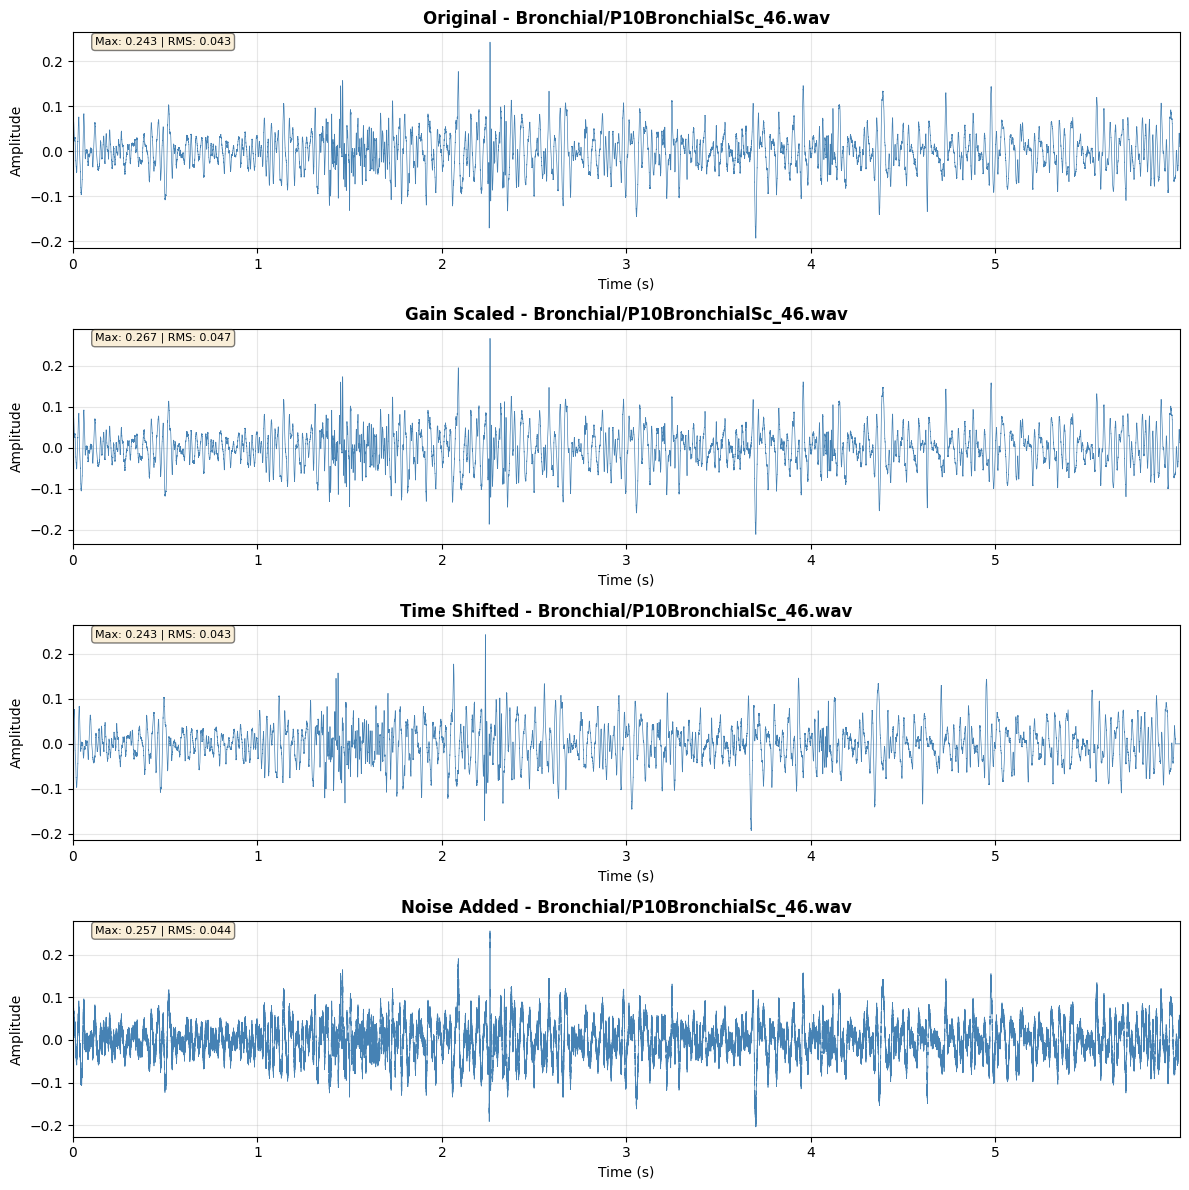

Plotted sample 1/5: P10BronchialSc_46.wav


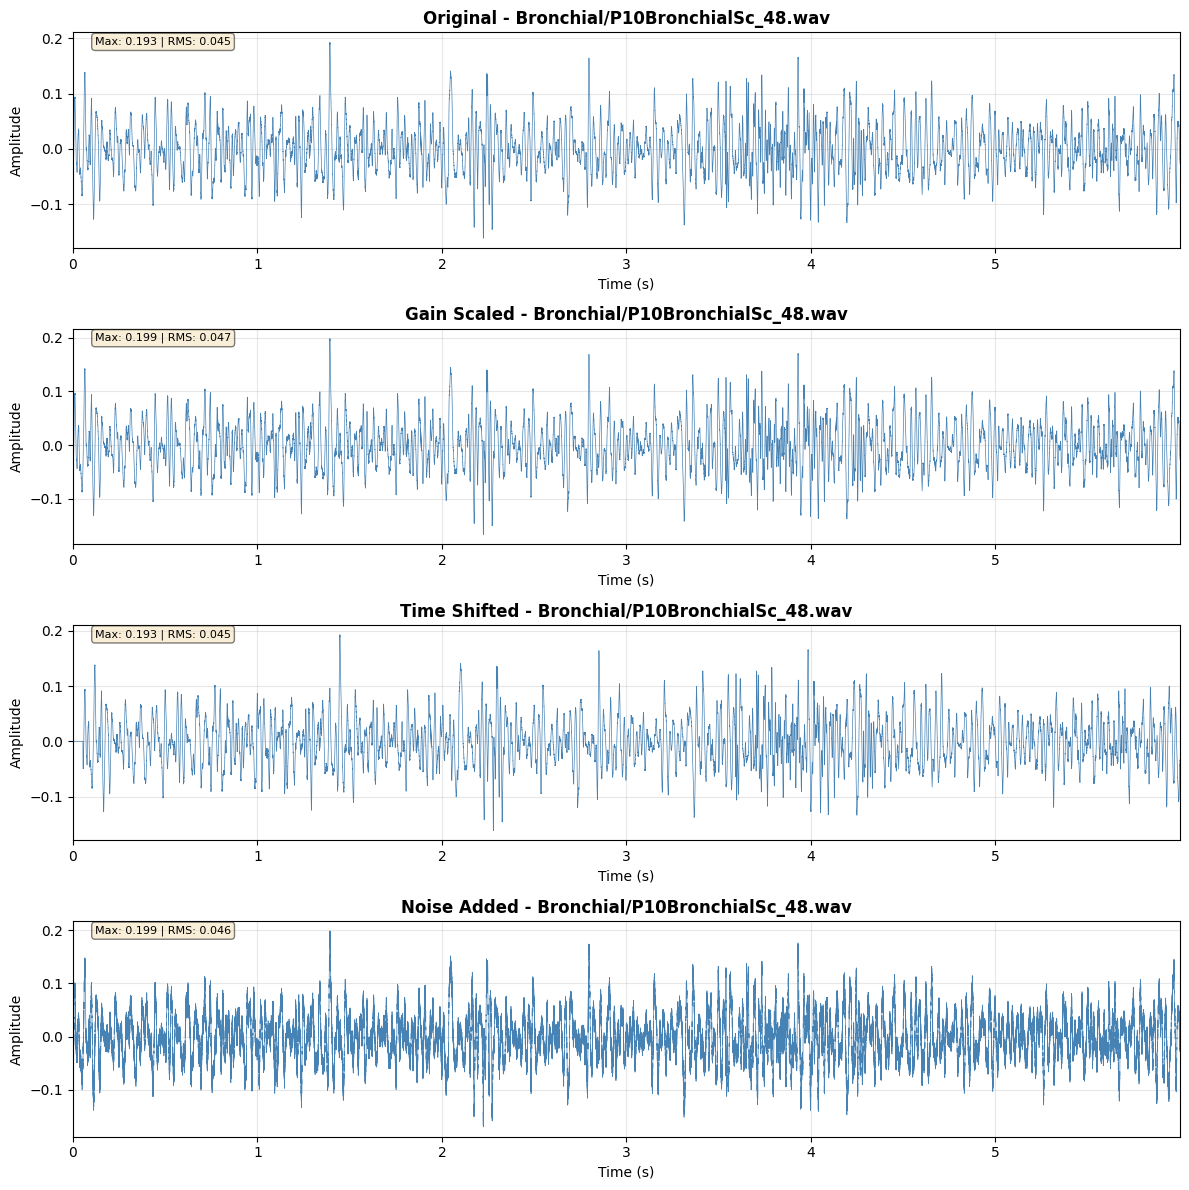

Plotted sample 2/5: P10BronchialSc_48.wav


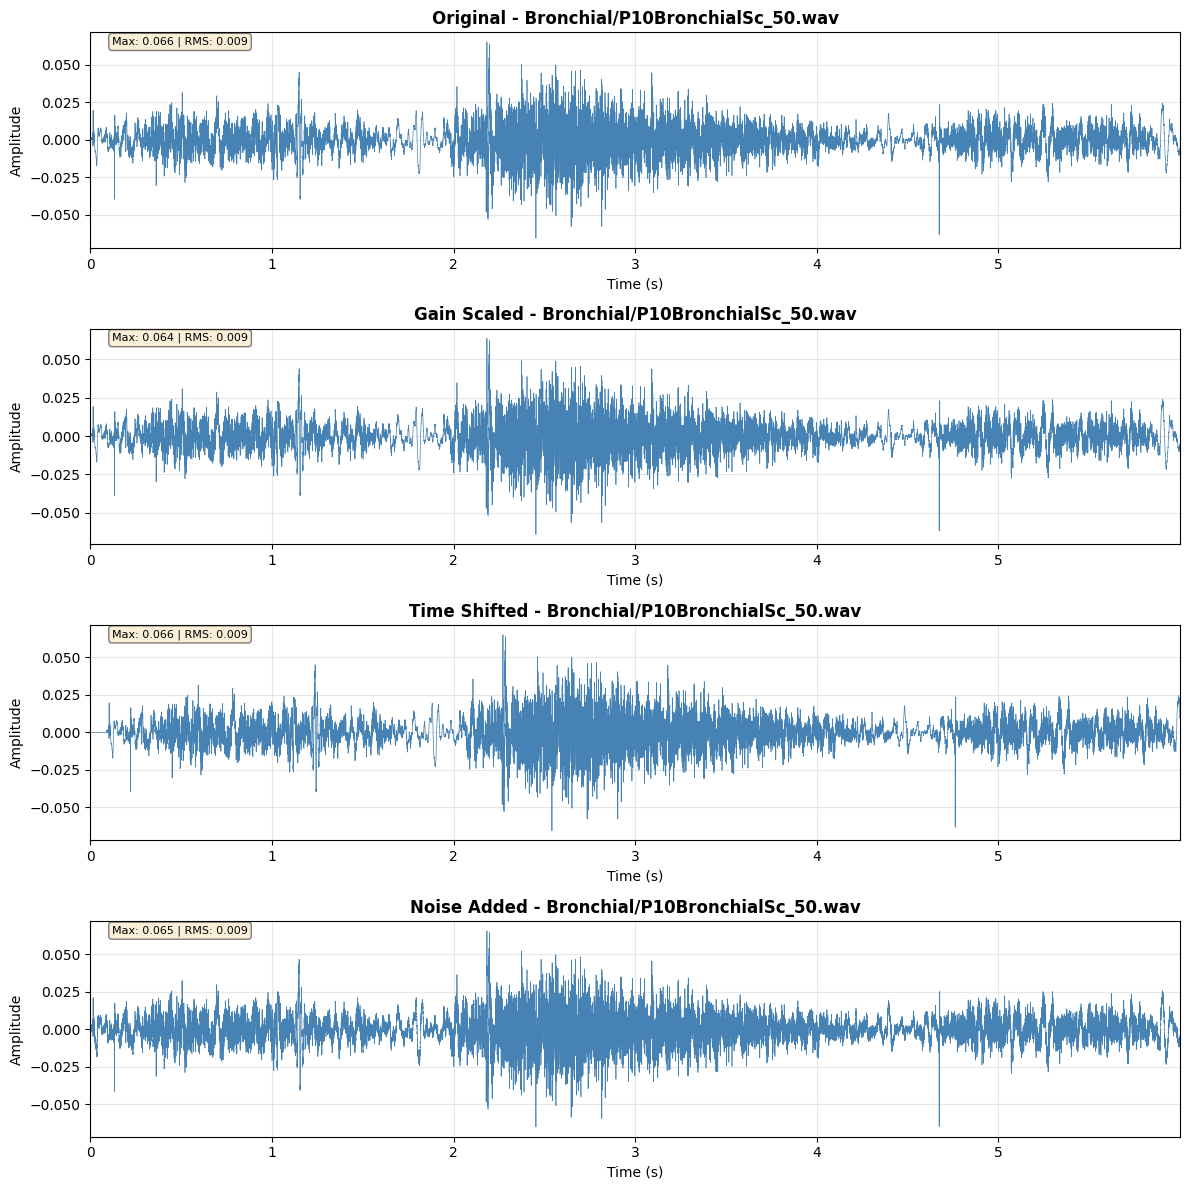

Plotted sample 3/5: P10BronchialSc_50.wav


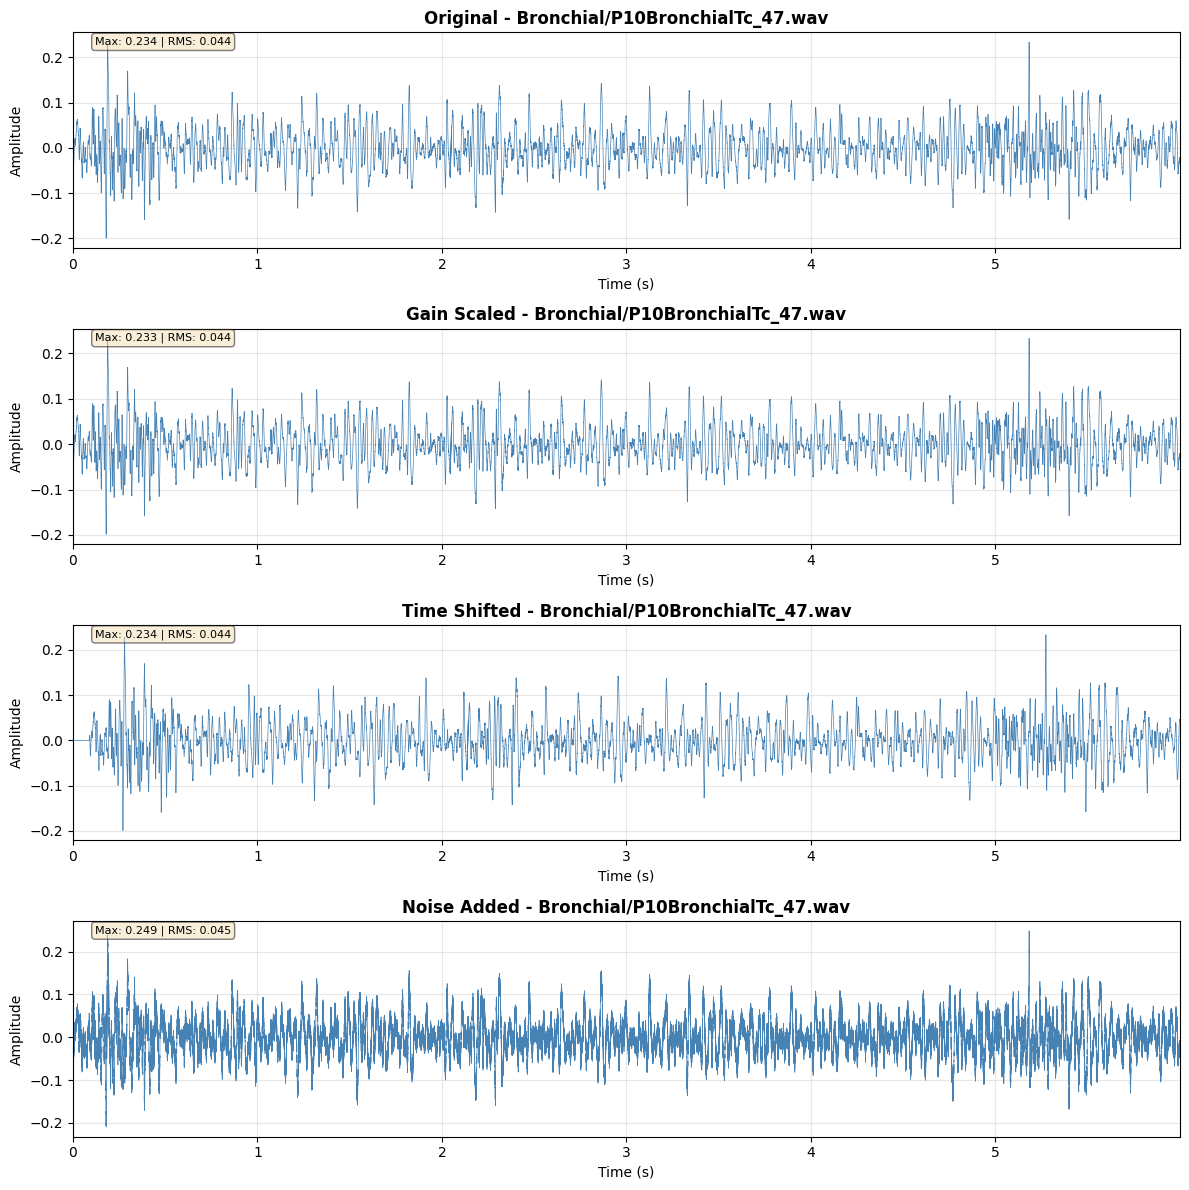

Plotted sample 4/5: P10BronchialTc_47.wav


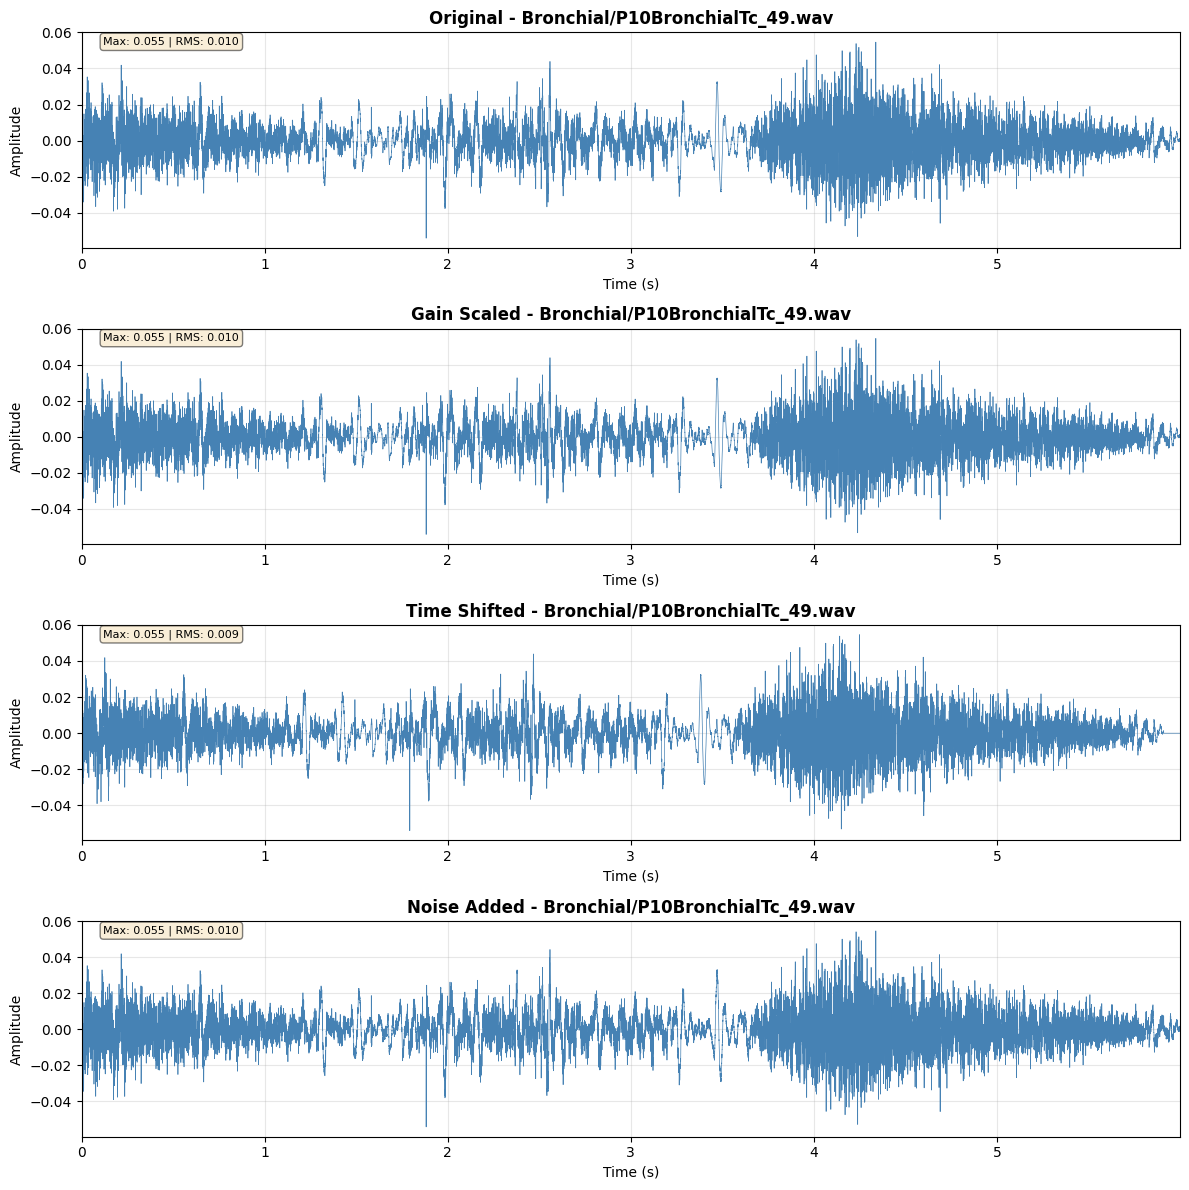

Plotted sample 5/5: P10BronchialTc_49.wav
****************************************


 Data loaded: 1211 audio files
 Classes: ['Bronchial', 'copd', 'healthy', 'pneumonia', 'asthma']

****************************************
STEP 2: CLEANING AND PREPROCESSING
****************************************

****************************************
APPLYING AUGMENTATION TO FULL DATASET
****************************************
Augmented 100/1211 samples...
Augmented 200/1211 samples...
Augmented 300/1211 samples...
Augmented 400/1211 samples...
Augmented 500/1211 samples...
Augmented 600/1211 samples...
Augmented 700/1211 samples...
Augmented 800/1211 samples...
Augmented 900/1211 samples...
Augmented 1000/1211 samples...
Augmented 1100/1211 samples...
Augmented 1200/1211 samples...

Augmentation complete!
Original samples: 1211
Augmented samples: 4844
Augmentation factor: 4.00x
Failed samples: 0
************************************************************


*************************************

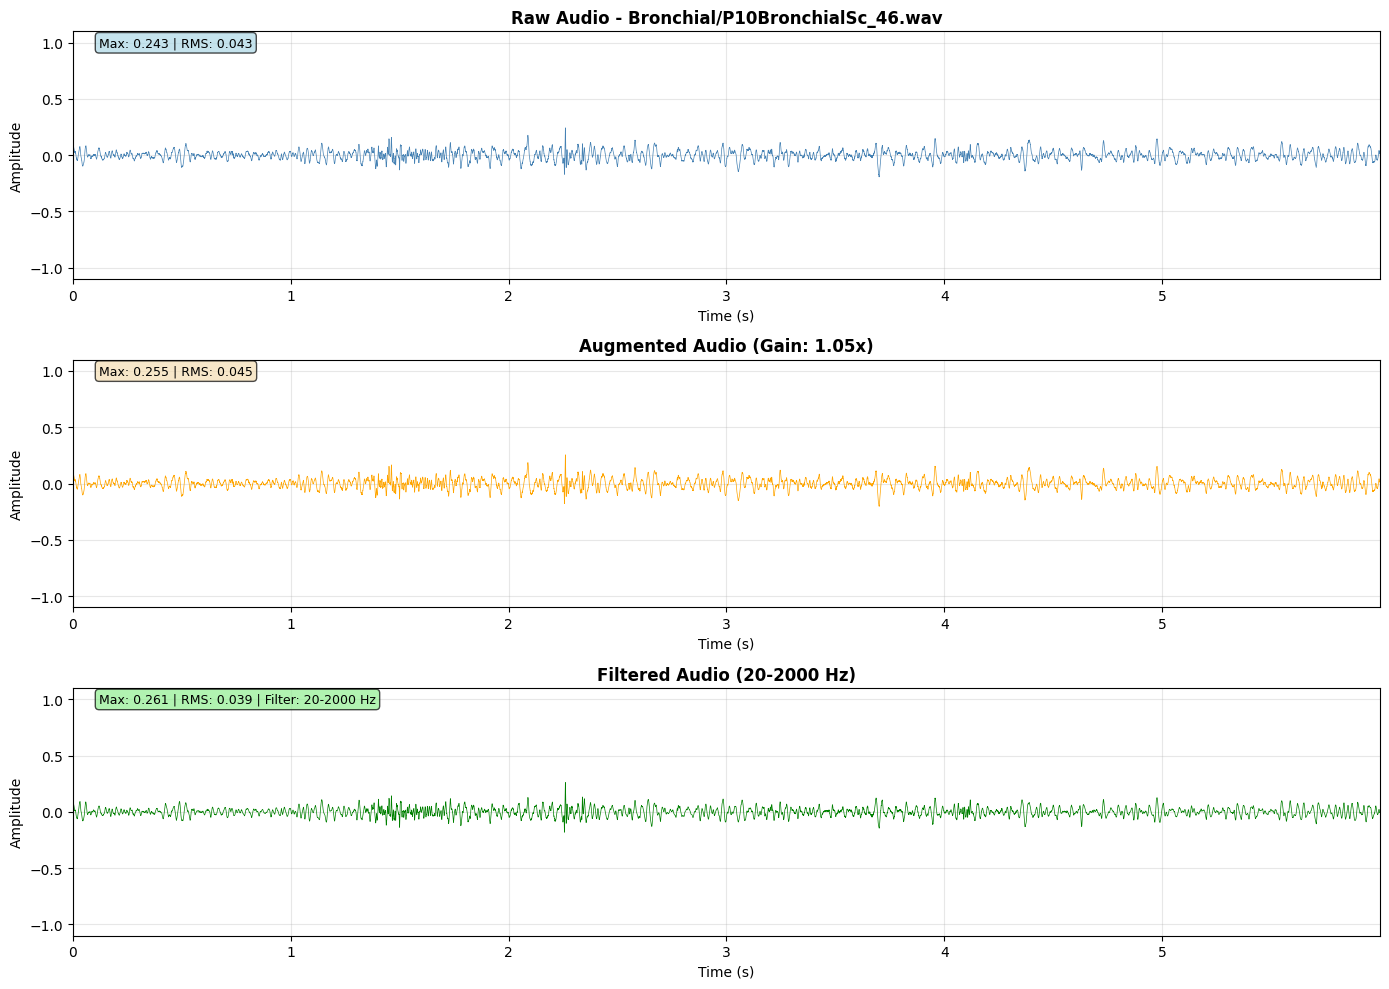

Plotted sample 1/5: P10BronchialSc_46.wav


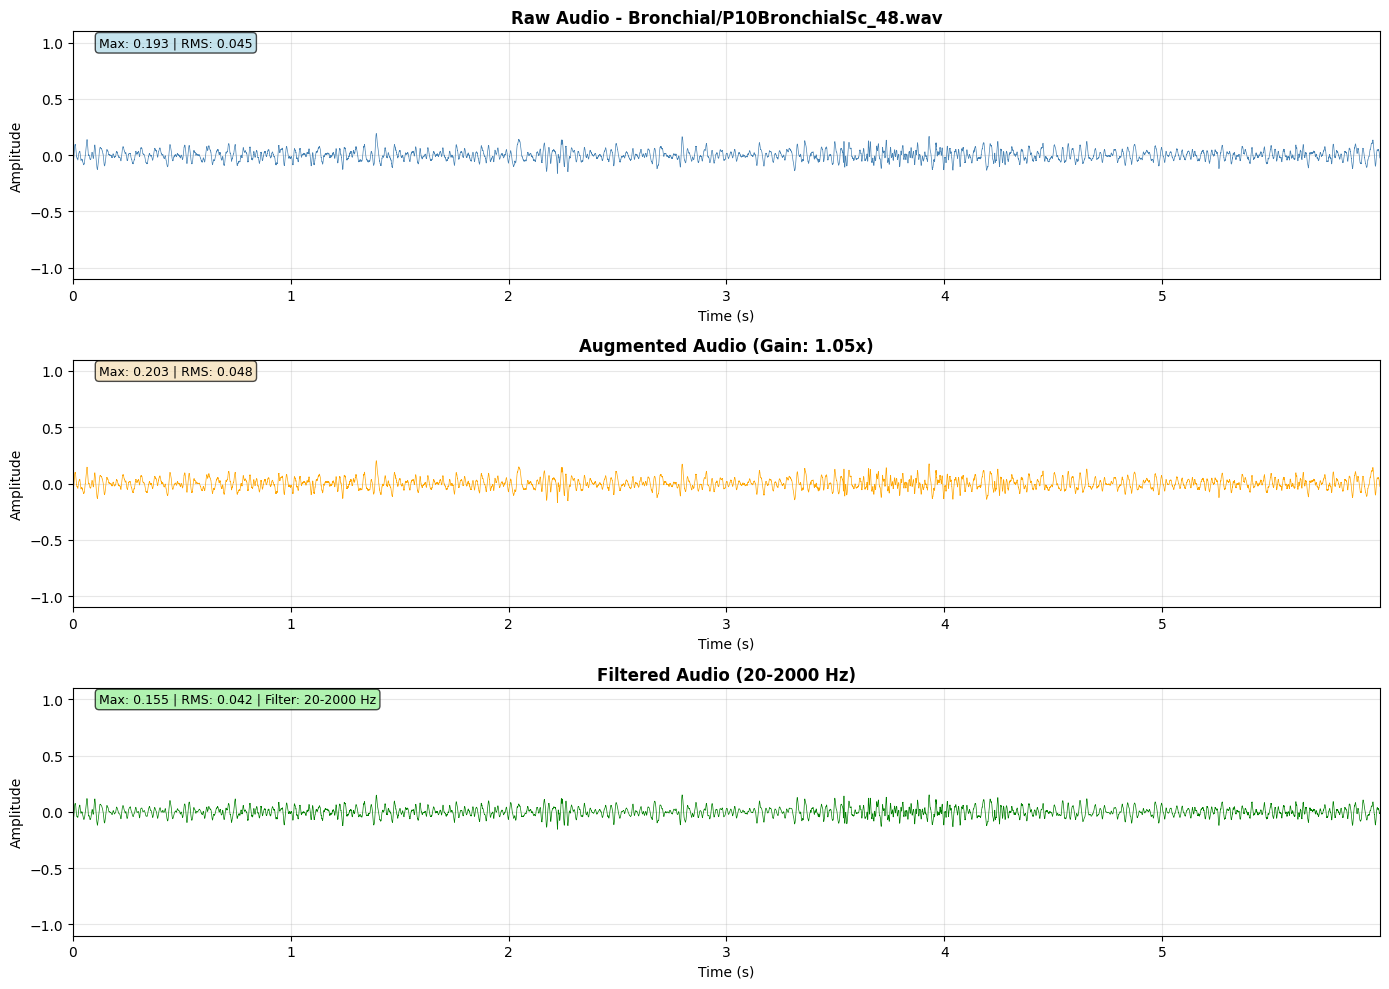

Plotted sample 2/5: P10BronchialSc_48.wav


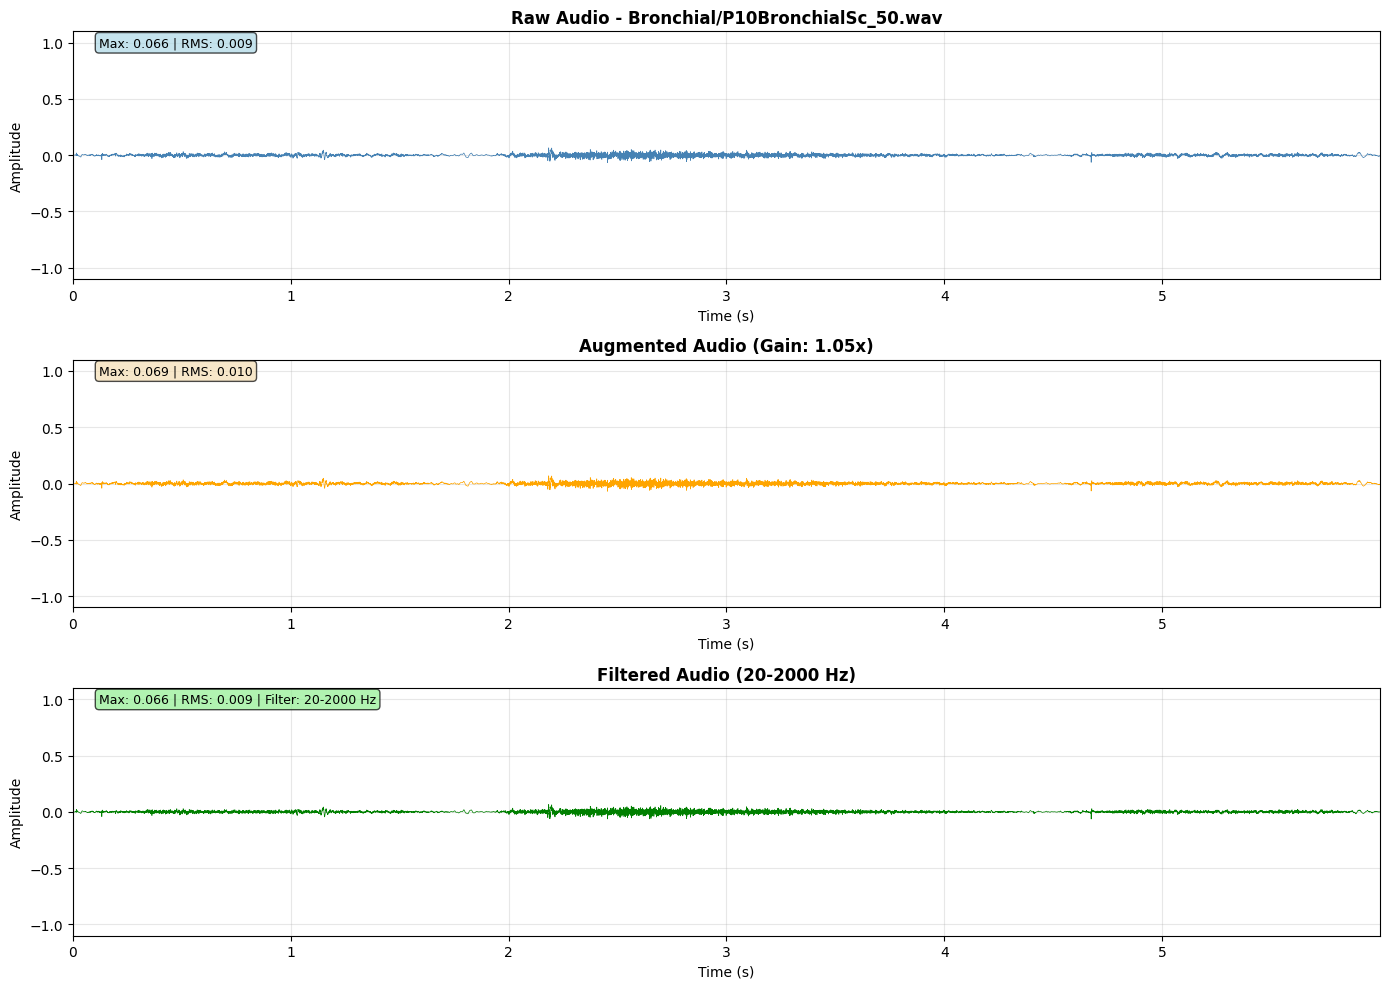

Plotted sample 3/5: P10BronchialSc_50.wav


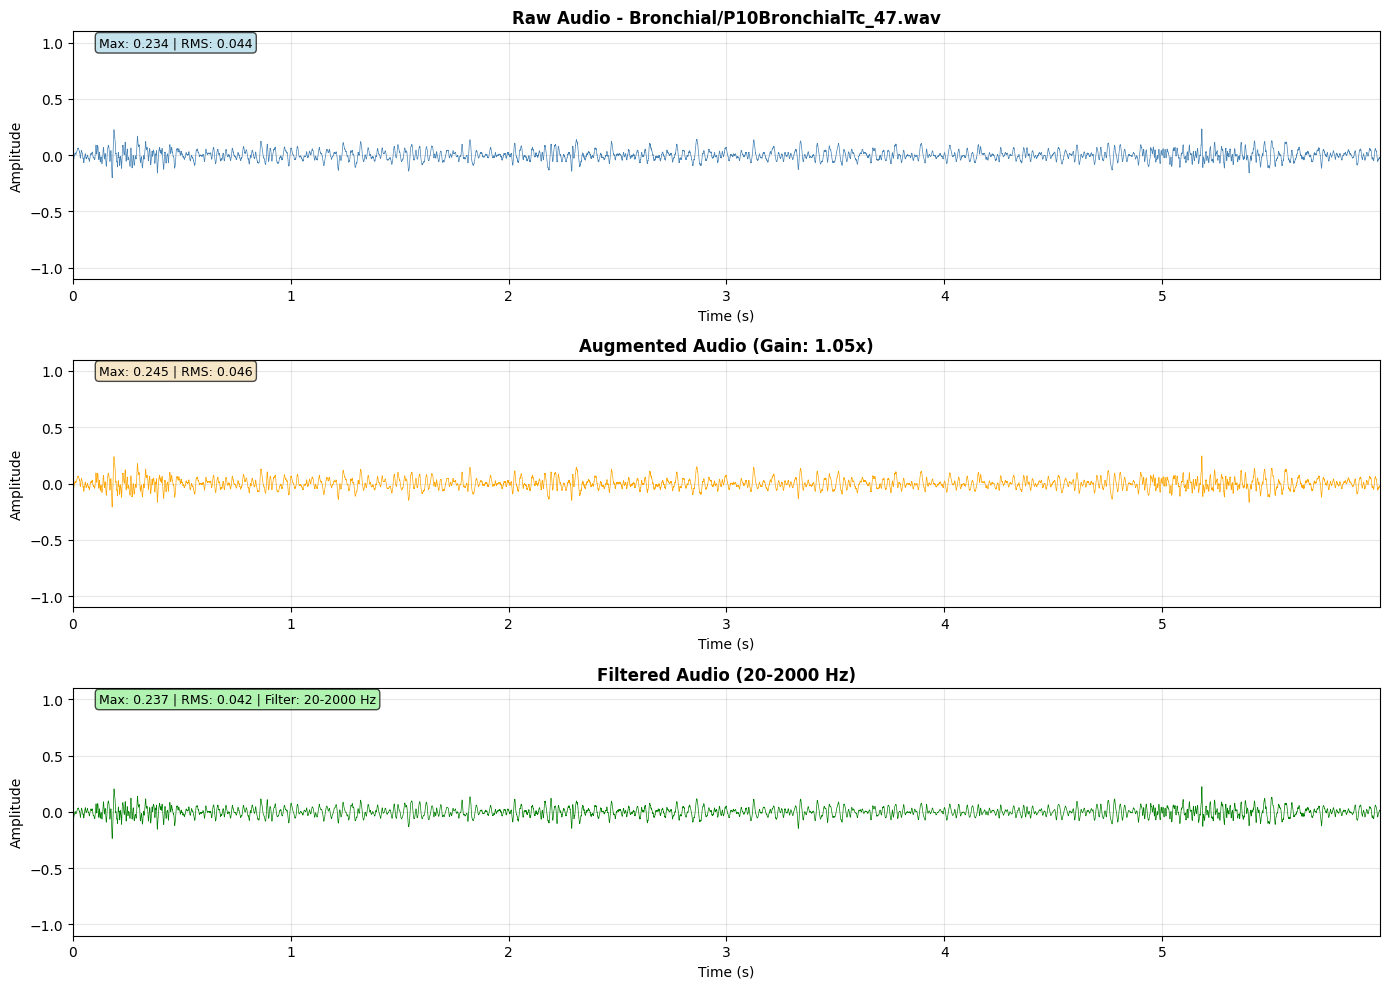

Plotted sample 4/5: P10BronchialTc_47.wav


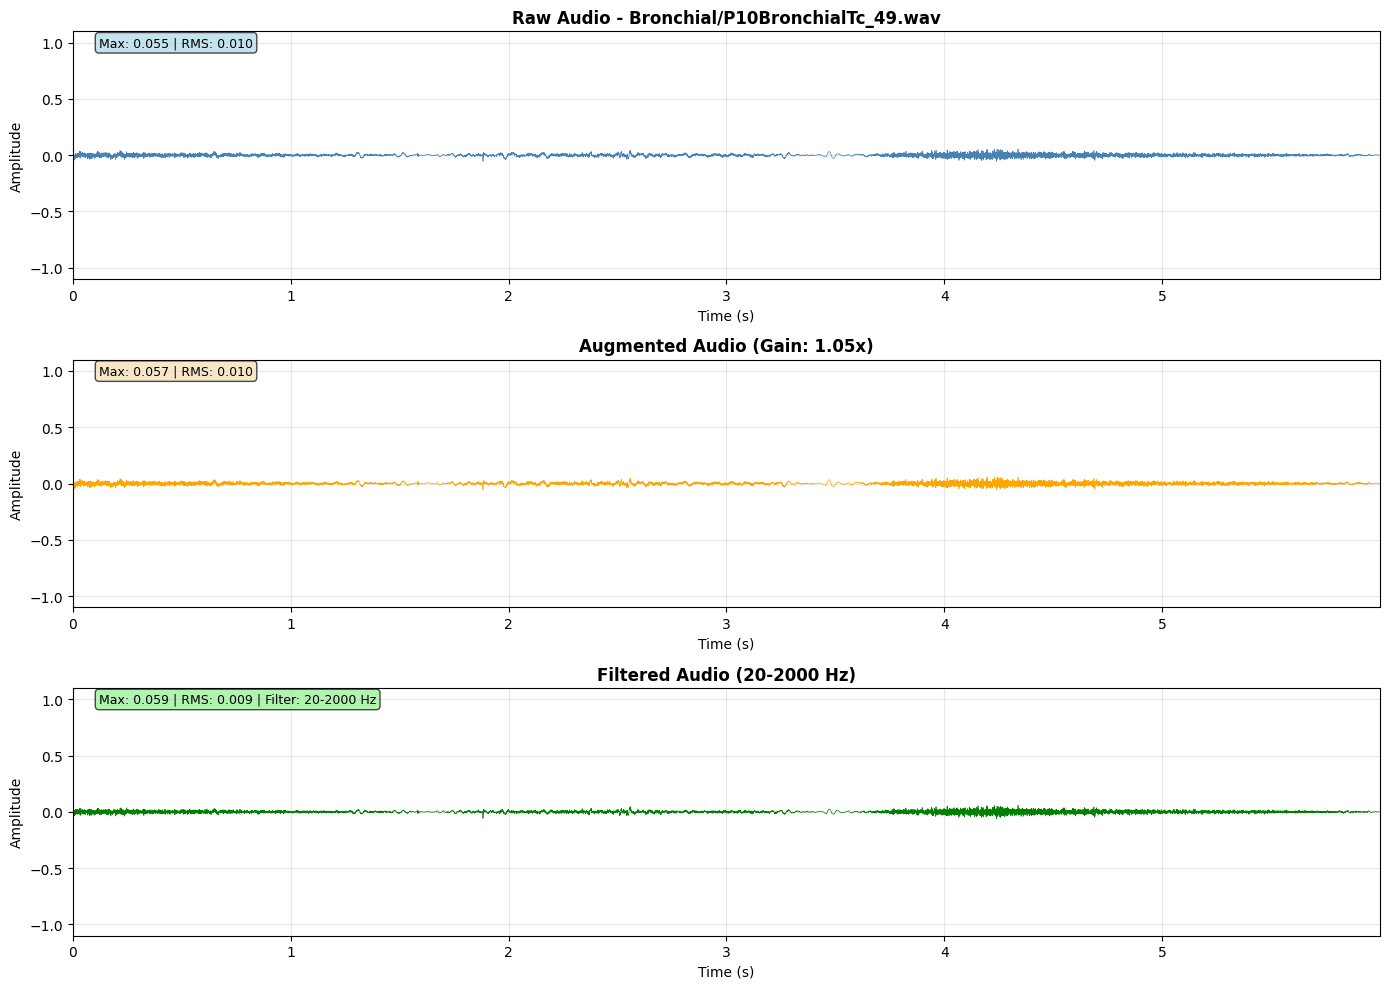

Plotted sample 5/5: P10BronchialTc_49.wav
****************************************


 Preprocessing complete: 4844 processed samples

****************************************
STEP 3: FEATURE EXTRACTION
****************************************

****************************************
EXTRACTING FEATURES FROM DATASET
****************************************
Extracted features from 100/4844 samples...
Extracted features from 200/4844 samples...
Extracted features from 300/4844 samples...
Extracted features from 400/4844 samples...
Extracted features from 500/4844 samples...
Extracted features from 600/4844 samples...
Extracted features from 700/4844 samples...
Extracted features from 800/4844 samples...
Extracted features from 900/4844 samples...
Extracted features from 1000/4844 samples...
Extracted features from 1100/4844 samples...
Extracted features from 1200/4844 samples...
Extracted features from 1300/4844 samples...
Extracted features from 1400/4844 samples...
Extracted features f

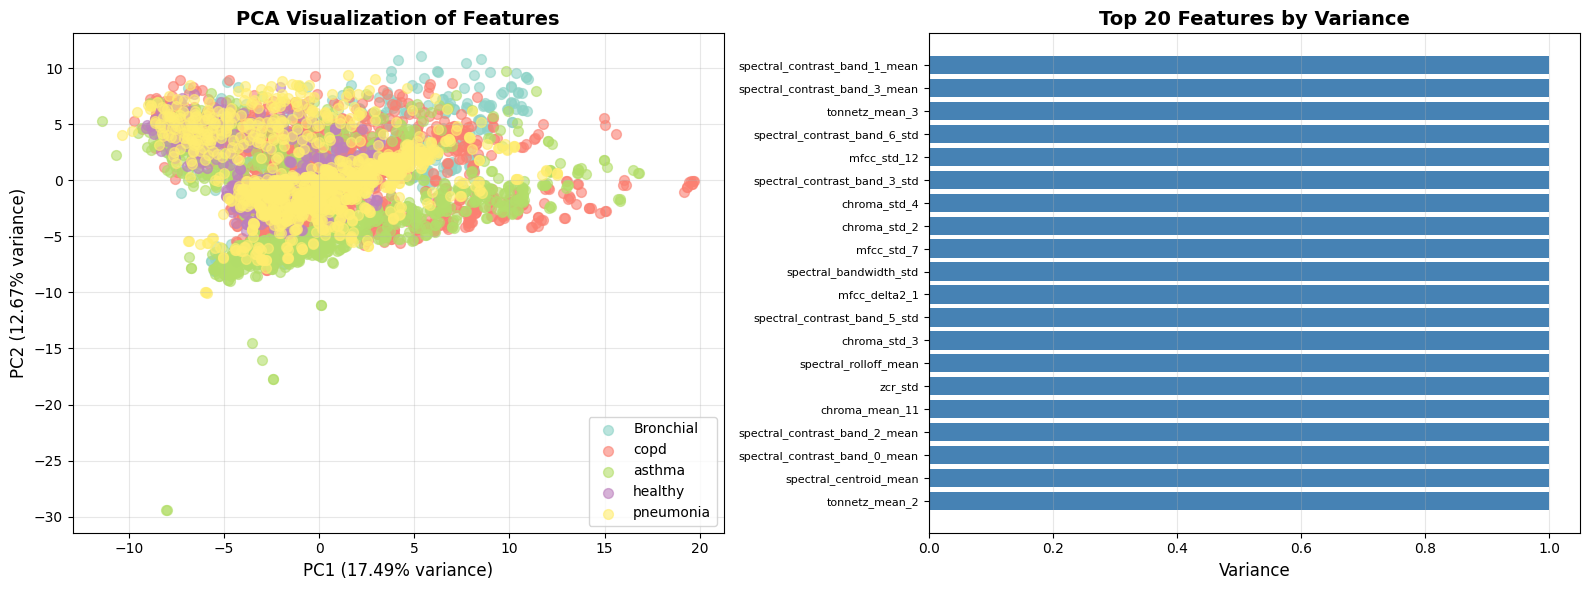

PCA explained variance ratio: [0.17489455 0.12666447]
Total explained variance: 30.16%
************************************************************

Saving extracted features...
Features saved to: models\extracted_features.pkl

****************************************
STEP 4: MODEL IMPLEMENTATION, TRAINING AND VALIDATION
****************************************

****************************************
TRAINING SVM MODEL
****************************************
Validation Accuracy: 0.9019
F1 Score: 0.9019
Precision: 0.9083
Recall: 0.9019
************************************************************


****************************************
TRAINING KNN MODEL
****************************************
Validation Accuracy: 0.8761
F1 Score: 0.8766
Precision: 0.8788
Recall: 0.8761
************************************************************

Preparing CNN data (mel spectrograms)...

****************************************
TRAINING CNN MODEL
****************************************
Epoch 1/5

97/97 ━━━━━━━━━━━━━━━━━━━━ 73s 700ms/step - accuracy: 0.4716 - loss: 1.4644 - val_accuracy: 0.1097 - val_loss: 30.7682
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - accuracy: 0.5797 - loss: 1.1276 - val_accuracy: 0.1097 - val_loss: 57.5051
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5917 - loss: 1.0402

97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 621ms/step - accuracy: 0.6039 - loss: 1.0260 - val_accuracy: 0.1148 - val_loss: 82.5595
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6660 - loss: 0.8814

97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 618ms/step - accuracy: 0.6777 - loss: 0.8599 - val_accuracy: 0.1187 - val_loss: 53.6873
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6908 - loss: 0.8123

97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 622ms/step - accuracy: 0.6923 - loss: 0.8007 - val_accuracy: 0.2284 - val_loss: 70.0920
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7358 - loss: 0.7211

97/97 ━━━━━━━━━━━━━━━━━━━━ 62s 639ms/step - accuracy: 0.7465 - loss: 0.6848 - val_accuracy: 0.2361 - val_loss: 283.8268
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 615ms/step - accuracy: 0.7958 - loss: 0.5790 - val_accuracy: 0.1406 - val_loss: 98.8475
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8244 - loss: 0.4785

97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 618ms/step - accuracy: 0.8181 - loss: 0.5048 - val_accuracy: 0.2400 - val_loss: 93.4366
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 631ms/step - accuracy: 0.8329 - loss: 0.4618 - val_accuracy: 0.2387 - val_loss: 216.6491
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.8717 - loss: 0.3715

97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 627ms/step - accuracy: 0.8694 - loss: 0.3828 - val_accuracy: 0.3161 - val_loss: 69.4078
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8867 - loss: 0.3237

97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 606ms/step - accuracy: 0.8942 - loss: 0.3148 - val_accuracy: 0.5600 - val_loss: 8.3294
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9135 - loss: 0.2493

97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 647ms/step - accuracy: 0.9103 - loss: 0.2620 - val_accuracy: 0.7923 - val_loss: 0.5836
Epoch 13/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 609ms/step - accuracy: 0.9232 - loss: 0.2277 - val_accuracy: 0.2374 - val_loss: 468.3253
Epoch 14/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 611ms/step - accuracy: 0.9200 - loss: 0.2410 - val_accuracy: 0.2387 - val_loss: 210.6694
Epoch 15/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 607ms/step - accuracy: 0.9306 - loss: 0.2010 - val_accuracy: 0.2581 - val_loss: 118.3557
Epoch 16/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 621ms/step - accuracy: 0.9532 - loss: 0.1458 - val_accuracy: 0.3174 - val_loss: 69.8445
Epoch 17/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 62s 635ms/step - accuracy: 0.9594 - loss: 0.1275 - val_accuracy: 0.7123 - val_loss: 1.4559
Epoch 18/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 630ms/step - accuracy: 0.9606 - loss: 0.1232 - val_accuracy: 0.7897 - val_loss: 1.2459
Epoch 19/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9740 - loss: 0.0971

97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 622ms/step - accuracy: 0.9684 - loss: 0.1062 - val_accuracy: 0.8335 - val_loss: 0.6886
Epoch 20/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9706 - loss: 0.1022

97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 650ms/step - accuracy: 0.9713 - loss: 0.0958 - val_accuracy: 0.8361 - val_loss: 0.7222
Epoch 21/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 647ms/step - accuracy: 0.9710 - loss: 0.0814 - val_accuracy: 0.8271 - val_loss: 0.9827
Epoch 22/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 649ms/step - accuracy: 0.9774 - loss: 0.0821 - val_accuracy: 0.7832 - val_loss: 4.0368
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step
Validation Accuracy: 0.7923
F1 Score: 0.7934
Precision: 0.8197
Recall: 0.7923
************************************************************

Preparing LSTM data (MFCC sequences)...

****************************************
TRAINING LSTM MODEL
****************************************
Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3216 - loss: 2.0159

97/97 ━━━━━━━━━━━━━━━━━━━━ 29s 244ms/step - accuracy: 0.3784 - loss: 1.7855 - val_accuracy: 0.5316 - val_loss: 1.3070
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4739 - loss: 1.4684

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.4816 - loss: 1.4058 - val_accuracy: 0.5858 - val_loss: 1.1160
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.5365 - loss: 1.2296 - val_accuracy: 0.5845 - val_loss: 1.0835
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5180 - loss: 1.1935

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.5561 - loss: 1.1452 - val_accuracy: 0.6219 - val_loss: 0.9703
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.5845 - loss: 1.0676 - val_accuracy: 0.5961 - val_loss: 1.0188
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6043 - loss: 1.0623

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.6019 - loss: 1.0352 - val_accuracy: 0.6297 - val_loss: 0.9144
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6106 - loss: 0.9991

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.6058 - loss: 1.0130 - val_accuracy: 0.6323 - val_loss: 0.9234
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6005 - loss: 1.0386

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.6106 - loss: 0.9975 - val_accuracy: 0.6465 - val_loss: 0.9074
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6456 - loss: 0.9356

97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - accuracy: 0.6332 - loss: 0.9572 - val_accuracy: 0.6594 - val_loss: 0.8564
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.6452 - loss: 0.9291 - val_accuracy: 0.6284 - val_loss: 0.9366
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.6465 - loss: 0.9238 - val_accuracy: 0.6503 - val_loss: 0.8735
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.6506 - loss: 0.9011 - val_accuracy: 0.6503 - val_loss: 0.8766
Epoch 13/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6695 - loss: 0.8766

97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.6532 - loss: 0.8997 - val_accuracy: 0.6735 - val_loss: 0.8160
Epoch 14/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.6606 - loss: 0.8750 - val_accuracy: 0.6529 - val_loss: 0.8633
Epoch 15/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.6658 - loss: 0.8528 - val_accuracy: 0.6671 - val_loss: 0.8713
Epoch 16/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6848 - loss: 0.8270

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.6842 - loss: 0.8300 - val_accuracy: 0.6942 - val_loss: 0.7658
Epoch 17/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6820 - loss: 0.8440

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.6919 - loss: 0.8183 - val_accuracy: 0.7084 - val_loss: 0.7759
Epoch 18/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6900 - loss: 0.8114

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.6855 - loss: 0.8242 - val_accuracy: 0.7174 - val_loss: 0.7531
Epoch 19/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6909 - loss: 0.7946

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.6965 - loss: 0.7925 - val_accuracy: 0.7200 - val_loss: 0.7602
Epoch 20/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.6984 - loss: 0.8022 - val_accuracy: 0.6813 - val_loss: 0.8172
Epoch 21/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.7042 - loss: 0.7917 - val_accuracy: 0.7161 - val_loss: 0.7329
Epoch 22/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6976 - loss: 0.8076

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.7032 - loss: 0.7914 - val_accuracy: 0.7316 - val_loss: 0.7152
Epoch 23/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.6965 - loss: 0.7978 - val_accuracy: 0.7019 - val_loss: 0.7747
Epoch 24/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7356 - loss: 0.7359

97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.7239 - loss: 0.7473 - val_accuracy: 0.7329 - val_loss: 0.7175
Epoch 25/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.7248 - loss: 0.7443 - val_accuracy: 0.6929 - val_loss: 0.8129
Epoch 26/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - accuracy: 0.7065 - loss: 0.7593 - val_accuracy: 0.7123 - val_loss: 0.7675
Epoch 27/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.7352 - loss: 0.7190 - val_accuracy: 0.7161 - val_loss: 0.7176
Epoch 28/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.7319 - loss: 0.7055 - val_accuracy: 0.7200 - val_loss: 0.7210
Epoch 29/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7383 - loss: 0.6953

97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.7310 - loss: 0.7116 - val_accuracy: 0.7432 - val_loss: 0.7045
Epoch 30/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.7452 - loss: 0.6860 - val_accuracy: 0.7316 - val_loss: 0.7215
Epoch 31/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.7429 - loss: 0.6932 - val_accuracy: 0.6903 - val_loss: 0.8421
Epoch 32/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.7410 - loss: 0.6991 - val_accuracy: 0.7161 - val_loss: 0.7755
Epoch 33/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.7452 - loss: 0.6804 - val_accuracy: 0.7419 - val_loss: 0.6526
Epoch 34/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7492 - loss: 0.6392

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.7523 - loss: 0.6526 - val_accuracy: 0.7445 - val_loss: 0.6569
Epoch 35/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7587 - loss: 0.6442

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.7568 - loss: 0.6394 - val_accuracy: 0.7626 - val_loss: 0.6440
Epoch 36/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.7558 - loss: 0.6579 - val_accuracy: 0.7497 - val_loss: 0.6623
Epoch 37/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.7684 - loss: 0.6312 - val_accuracy: 0.7368 - val_loss: 0.6939
Epoch 38/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.7674 - loss: 0.6344 - val_accuracy: 0.7200 - val_loss: 0.7103
Epoch 39/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.7571 - loss: 0.6523 - val_accuracy: 0.7535 - val_loss: 0.6569
Epoch 40/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7626 - loss: 0.6219

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.7642 - loss: 0.6276 - val_accuracy: 0.7729 - val_loss: 0.6222
Epoch 41/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.7719 - loss: 0.6044 - val_accuracy: 0.7510 - val_loss: 0.6258
Epoch 42/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - accuracy: 0.7739 - loss: 0.6177 - val_accuracy: 0.7458 - val_loss: 0.7006
Epoch 43/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.7677 - loss: 0.6150 - val_accuracy: 0.7497 - val_loss: 0.6999
Epoch 44/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.7668 - loss: 0.6292 - val_accuracy: 0.7574 - val_loss: 0.5934
Epoch 45/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.7855 - loss: 0.5745 - val_accuracy: 0.7071 - val_loss: 0.7643
Epoch 46/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.7884 - loss: 0.5798 - val_accuracy: 0.7639 - val_loss: 0.6092
Epoch 47/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7894 - loss: 0.5437

97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.7884 - loss: 0.5518 - val_accuracy: 0.7755 - val_loss: 0.5858
Epoch 48/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.7865 - loss: 0.5674 - val_accuracy: 0.7535 - val_loss: 0.6154
Epoch 49/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7942 - loss: 0.5353

97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.7874 - loss: 0.5561 - val_accuracy: 0.7910 - val_loss: 0.5848
Epoch 50/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.7971 - loss: 0.5468 - val_accuracy: 0.7381 - val_loss: 0.7003
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step
Validation Accuracy: 0.7910
F1 Score: 0.7896
Precision: 0.8030
Recall: 0.7910
************************************************************


****************************************
ANALYZING FEATURE IMPORTANCE
****************************************
1. spectral_contrast_band_0_mean: 0.0362
2. spectral_bandwidth_mean: 0.0306
3. std_amplitude: 0.0289
4. spectral_contrast_band_4_mean: 0.0249
5. mfcc_mean_9: 0.0227
6. mfcc_mean_3: 0.0221
7. spectral_contrast_band_1_std: 0.0215
8. energy_std: 0.0199
9. spectral_contrast_band_5_mean: 0.0197
10. rms_energy: 0.0194
11. spectral_contrast_band_4_std: 0.0184
12. tonnetz_mean_2: 0.0172
13. energy: 0.0157
14. spectral_contrast_band_1_mean: 0.0148
15. chroma_mean_

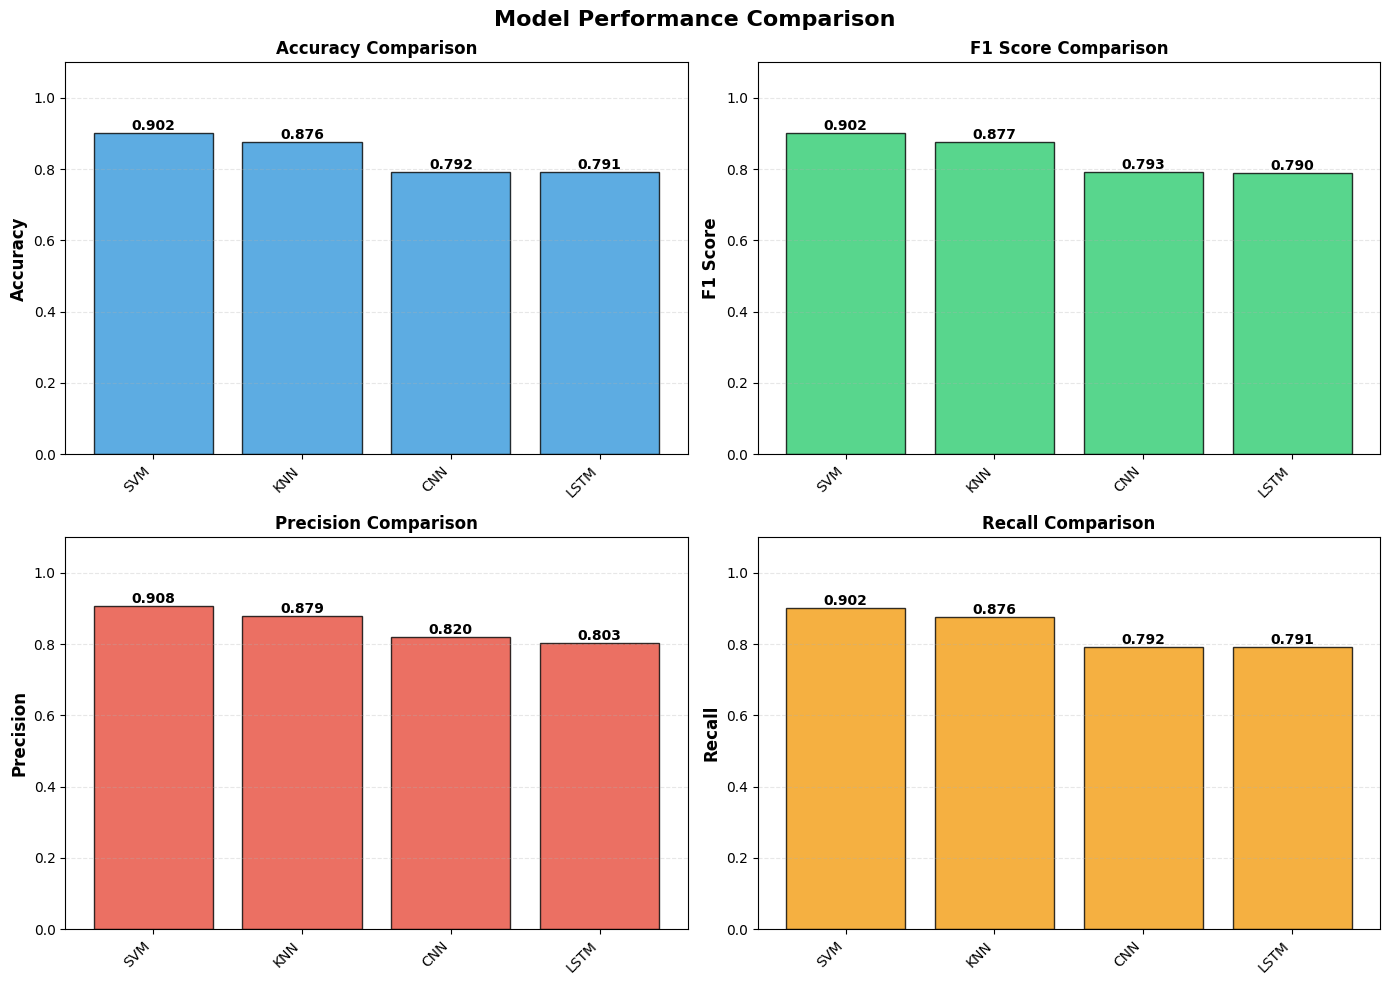

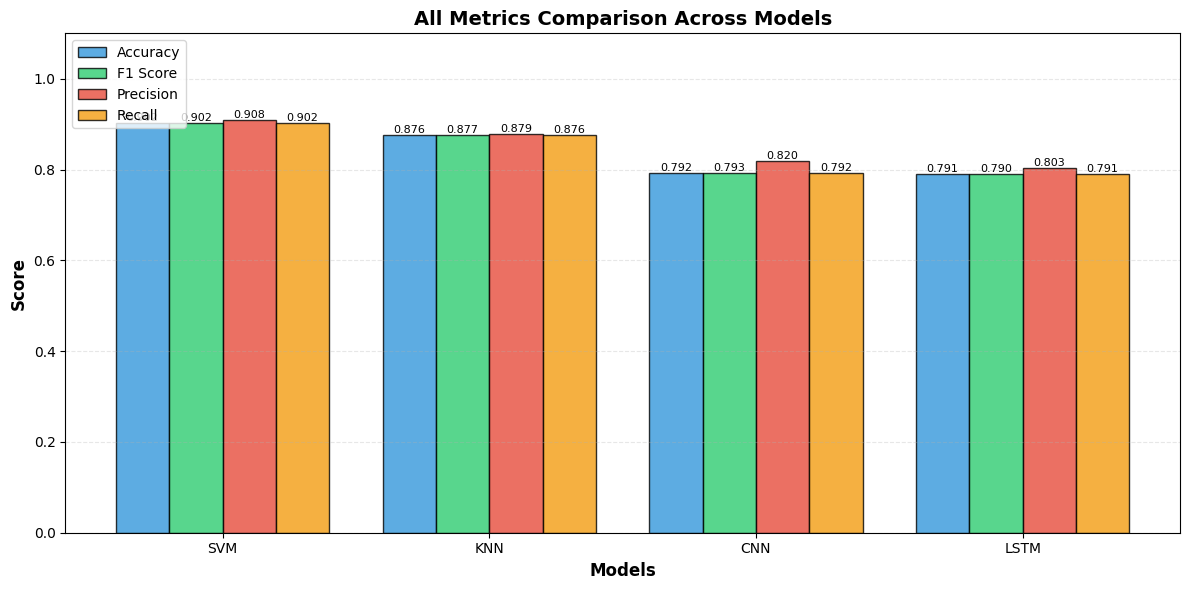

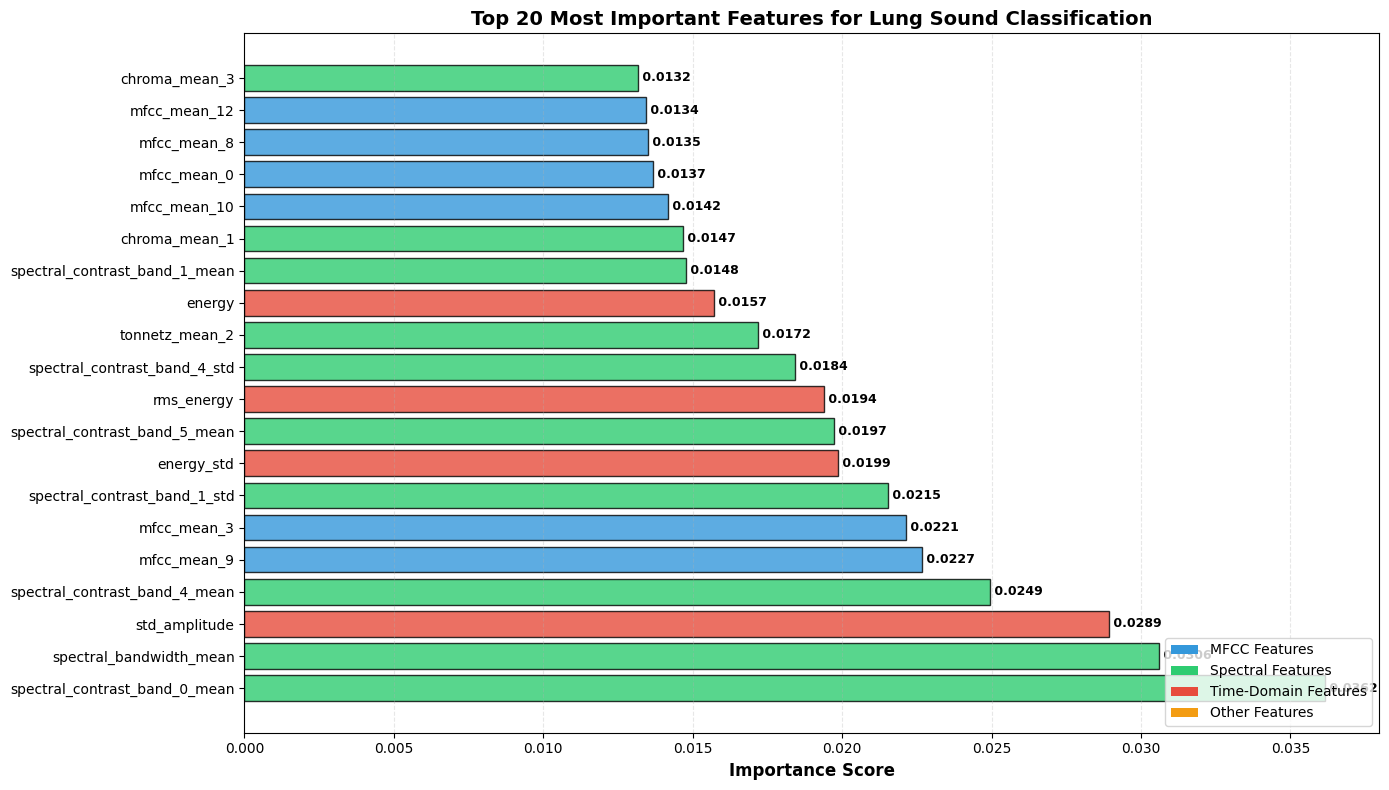

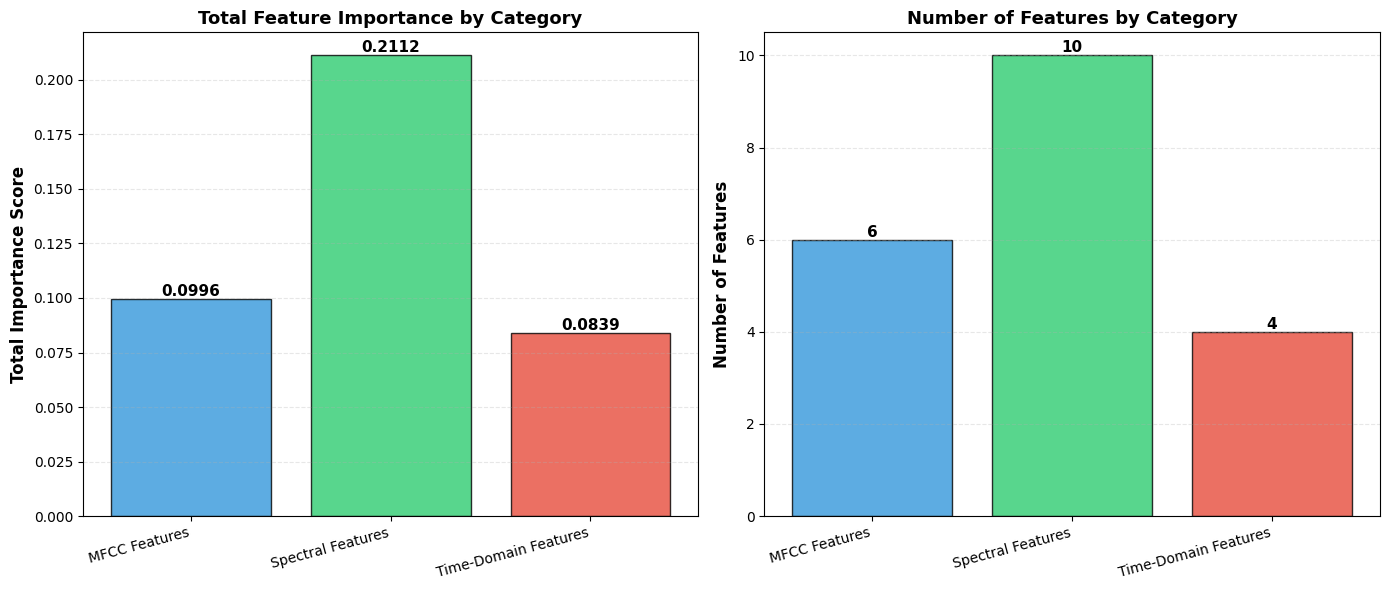


****************************************
STEP 5: OUTPUT - RESEARCH QUESTIONS RESULTS
****************************************

****************************************
COMPARING PREPROCESSING METHODS
****************************************
Note: Using sample of 100 files for speed comparison

Method 1: No preprocessing

****************************************
EXTRACTING FEATURES FROM DATASET
****************************************
Extracted features from 100/100 samples...

Feature extraction complete!
Total samples: 100
Successfully extracted: 100
Failed: 0
Feature vector shape: (100, 122)
Number of features: 122
****************************************


Method 2: Only filtering

****************************************
Filtering audio data (20-2000 Hz)...
****************************************

Filtered 100 audio files
Failed: 0
****************************************


****************************************
EXTRACTING FEATURES FROM DATASET
*********************************

In [17]:

# GUI APPLICATION FOR SINGLE FILE PREDICTION

def process_single_audio_file(file_path, target_sr=TARGET_SR):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=target_sr)
        audio = clean_nan_inf(audio)
        
        # Apply preprocessing (filtering)
        filtered_audio = apply_bandpass_filter(audio, lowcut=20, highcut=2000, fs=sr)
        filtered_audio = clean_nan_inf(filtered_audio)
        
        return {
            'audio': filtered_audio,
            'sr': sr,
            'filename': os.path.basename(file_path)
        }
    except Exception as e:
        raise Exception(f"Error processing audio file: {e}")

# Predict the lung sound class for a single audio file
# using all trained models and return their predictions.
def predict_lung_sound(file_path):
    try:
        # Process audio file
        processed_audio = process_single_audio_file(file_path)
        
        # Load models and scalers
        model_paths = {
            'svm': os.path.join(MODEL_DIR, 'svm_model.pkl'),
            'knn': os.path.join(MODEL_DIR, 'knn_model.pkl'),
            'scaler': os.path.join(MODEL_DIR, 'scaler.pkl'),
            'label_encoder': os.path.join(MODEL_DIR, 'label_encoder.pkl'),
            'cnn': os.path.join(MODEL_DIR, 'best_cnn_model.h5'),
            'lstm': os.path.join(MODEL_DIR, 'best_lstm_model.h5')
        }
        
        # Check if models exist
        missing_models = [name for name, path in model_paths.items() if not os.path.exists(path)]
        if missing_models:
            raise Exception(f"Models not found. Please train models first. Missing: {missing_models}")
        
        # Load traditional ML models
        svm_model = pickle.load(open(model_paths['svm'], 'rb'))
        knn_model = pickle.load(open(model_paths['knn'], 'rb'))
        scaler = pickle.load(open(model_paths['scaler'], 'rb'))
        le = pickle.load(open(model_paths['label_encoder'], 'rb'))
        
        # Extract features for traditional ML models
        features, feature_names = extract_all_features(
            processed_audio['audio'], 
            processed_audio['sr'], 
            n_mfcc=13, 
            n_fft=2048, 
            hop_length=512
        )
        
        # Scale features
        features_scaled = scaler.transform(features.reshape(1, -1))
        
        # Predictions from SVM and KNN
        svm_pred = svm_model.predict(features_scaled)[0]
        svm_proba = svm_model.predict_proba(features_scaled)[0]
        svm_class = le.inverse_transform([svm_pred])[0]
        
        knn_pred = knn_model.predict(features_scaled)[0]
        knn_proba = knn_model.predict_proba(features_scaled)[0]
        knn_class = le.inverse_transform([knn_pred])[0]
        
        predictions = {
            'SVM': {
                'class': svm_class,
                'probability': float(max(svm_proba)),
                'all_probabilities': {le.classes_[i]: float(svm_proba[i]) for i in range(len(le.classes_))}
            },
            'KNN': {
                'class': knn_class,
                'probability': float(max(knn_proba)),
                'all_probabilities': {le.classes_[i]: float(knn_proba[i]) for i in range(len(le.classes_))}
            }
        }
        
        # Try to load and use CNN model
        try:
            cnn_model = load_model(model_paths['cnn'])
            X_cnn, _, _ = prepare_cnn_data([processed_audio])
            cnn_proba = cnn_model.predict(X_cnn, verbose=0)[0]
            cnn_pred = np.argmax(cnn_proba)
            cnn_class = le.inverse_transform([cnn_pred])[0]
            
            predictions['CNN'] = {
                'class': cnn_class,
                'probability': float(max(cnn_proba)),
                'all_probabilities': {le.classes_[i]: float(cnn_proba[i]) for i in range(len(le.classes_))}
            }
        except Exception as e:
            print(f"CNN prediction failed: {e}")
        
        # Try to load and use LSTM model
        try:
            lstm_model = load_model(model_paths['lstm'])
            X_lstm, _, _ = prepare_lstm_data([processed_audio])
            lstm_proba = lstm_model.predict(X_lstm, verbose=0)[0]
            lstm_pred = np.argmax(lstm_proba)
            lstm_class = le.inverse_transform([lstm_pred])[0]
            
            predictions['LSTM'] = {
                'class': lstm_class,
                'probability': float(max(lstm_proba)),
                'all_probabilities': {le.classes_[i]: float(lstm_proba[i]) for i in range(len(le.classes_))}
            }
        except Exception as e:
            print(f"LSTM prediction failed: {e}")
        
        # Get consensus prediction (most common class)
        all_predictions = [pred['class'] for pred in predictions.values()]
        consensus_class = max(set(all_predictions), key=all_predictions.count)
        
        predictions['Consensus'] = {
            'class': consensus_class,
            'agreement': all_predictions.count(consensus_class) / len(all_predictions)
        }
        
        return predictions
        
    except Exception as e:
        raise Exception(f"Prediction error: {e}")

# Function to create a simple gui for lung sound classification
def create_gui():
    root = tk.Tk()
    root.title("Lung Sound Classification System")
    root.geometry("800x700")
    root.configure(bg='#f0f0f0')
    
    # Title
    title_frame = tk.Frame(root, bg='#2c3e50', height=80)
    title_frame.pack(fill=tk.X)
    title_frame.pack_propagate(False)
    
    title_label = tk.Label(
        title_frame,
        text="Lung Sound Classification System",
        font=('Arial', 20, 'bold'),
        fg='white',
        bg='#2c3e50'
    )
    title_label.pack(pady=20)
    
    # Main content frame
    content_frame = tk.Frame(root, bg='#f0f0f0', padx=20, pady=20)
    content_frame.pack(fill=tk.BOTH, expand=True)
    
    # File selection frame
    file_frame = tk.Frame(content_frame, bg='#f0f0f0')
    file_frame.pack(fill=tk.X, pady=10)
    
    file_label = tk.Label(
        file_frame,
        text="Select WAV file:",
        font=('Arial', 12),
        bg='#f0f0f0'
    )
    file_label.pack(side=tk.LEFT, padx=5)
    
    file_path_var = tk.StringVar()
    file_entry = tk.Entry(
        file_frame,
        textvariable=file_path_var,
        font=('Arial', 10),
        width=50,
        state='readonly'
    )
    file_entry.pack(side=tk.LEFT, padx=5, fill=tk.X, expand=True)
    
    def browse_file():
        filename = filedialog.askopenfilename(
            title="Select WAV file",
            filetypes=[("WAV files", "*.wav"), ("All files", "*.*")]
        )
        if filename:
            file_path_var.set(filename)
            result_text.delete(1.0, tk.END)
            result_text.insert(tk.END, f"File selected: {os.path.basename(filename)}\n")
    
    browse_btn = tk.Button(
        file_frame,
        text="Browse",
        command=browse_file,
        font=('Arial', 10),
        bg='#3498db',
        fg='white',
        padx=15,
        pady=5,
        cursor='hand2'
    )
    browse_btn.pack(side=tk.LEFT, padx=5)
    
    # Predict button
    predict_btn = tk.Button(
        content_frame,
        text="Analyze Lung Sound",
        command=lambda: analyze_file(file_path_var.get()),
        font=('Arial', 14, 'bold'),
        bg='#27ae60',
        fg='white',
        padx=20,
        pady=10,
        cursor='hand2',
        relief=tk.RAISED,
        bd=3
    )
    predict_btn.pack(pady=20)
    
    # Results frame
    results_frame = tk.Frame(content_frame, bg='#f0f0f0')
    results_frame.pack(fill=tk.BOTH, expand=True)
    
    result_label = tk.Label(
        results_frame,
        text="Results:",
        font=('Arial', 12, 'bold'),
        bg='#f0f0f0'
    )
    result_label.pack(anchor=tk.W, pady=(0, 5))
    
    # Results text area with scrollbar
    scroll_frame = tk.Frame(results_frame, bg='#f0f0f0')
    scroll_frame.pack(fill=tk.BOTH, expand=True)
    
    result_text = tk.Text(
        scroll_frame,
        font=('Courier', 11),
        bg='white',
        wrap=tk.WORD,
        padx=10,
        pady=10,
        relief=tk.SUNKEN,
        bd=2
    )
    result_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
    
    scrollbar = tk.Scrollbar(scroll_frame, command=result_text.yview)
    scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
    result_text.config(yscrollcommand=scrollbar.set)
    
    # Initial message
    result_text.insert(tk.END, "Welcome to Lung Sound Classification System!\n\n")
    result_text.insert(tk.END, "Instructions:\n")
    result_text.insert(tk.END, "1. Click 'Browse' to select a WAV file\n")
    result_text.insert(tk.END, "2. Click 'Analyze Lung Sound' to get predictions\n")
    result_text.insert(tk.END, "3. Results will show predictions from all models\n\n")
    result_text.insert(tk.END, "Supported classes: Bronchial, COPD, Healthy, Pneumonia, Asthma\n")

    #Analyze the selected file and display results.
    def analyze_file(file_path):
        if not file_path or not os.path.exists(file_path):
            messagebox.showerror("Error", "Please select a valid WAV file first!")
            return
        
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "Analyzing lung sound...\n")
        result_text.insert(tk.END, f"File: {os.path.basename(file_path)}\n")
        result_text.insert(tk.END, "="*60 + "\n\n")
        root.update()
        
        try:
            predictions = predict_lung_sound(file_path)
            
            # Display results
            result_text.insert(tk.END, "PREDICTION RESULTS\n")
            result_text.insert(tk.END, "="*60 + "\n\n")
            
            # Consensus prediction (highlighted)
            consensus = predictions.get('Consensus', {})
            result_text.insert(tk.END, f" CONSENSUS PREDICTION:\n", 'bold')
            result_text.insert(tk.END, f"   Class: {consensus.get('class', 'N/A')}\n")
            result_text.insert(tk.END, f"   Agreement: {consensus.get('agreement', 0)*100:.1f}% of models\n\n")
            
            # Individual model predictions
            result_text.insert(tk.END, "Individual Model Predictions:\n")
            result_text.insert(tk.END, "-"*60 + "\n\n")
            
            for model_name in ['SVM', 'KNN', 'CNN', 'LSTM']:
                if model_name in predictions:
                    pred = predictions[model_name]
                    result_text.insert(tk.END, f"{model_name} Model:\n")
                    result_text.insert(tk.END, f"  Predicted Class: {pred['class']}\n")
                    result_text.insert(tk.END, f"  Confidence: {pred['probability']*100:.2f}%\n")
                    result_text.insert(tk.END, "\n  All Class Probabilities:\n")
                    
                    # Sort probabilities
                    sorted_probs = sorted(
                        pred['all_probabilities'].items(),
                        key=lambda x: x[1],
                        reverse=True
                    )
                    
                    for class_name, prob in sorted_probs:
                        bar_length = int(prob * 30)
                        bar = "█" * bar_length
                        result_text.insert(tk.END, f"    {class_name:12s} {prob*100:6.2f}% {bar}\n")
                    
                    result_text.insert(tk.END, "\n")
            
            result_text.insert(tk.END, "="*60 + "\n")
            result_text.insert(tk.END, "\nAnalysis complete!\n")
            
            # Configure text tags for formatting
            result_text.tag_config('bold', font=('Courier', 11, 'bold'))
            
            # Create bar graph for model comparison
            try:
                # Create a new window for graphs
                graph_window = tk.Toplevel(root)
                graph_window.title("Model Comparison - Bar Graphs")
                graph_window.geometry("1000x600")
                
                # Create figure
                fig = Figure(figsize=(10, 6), dpi=100)
                
                # Extract data for bar graph
                model_names = []
                accuracies = []
                for model_name in ['SVM', 'KNN', 'CNN', 'LSTM']:
                    if model_name in predictions:
                        model_names.append(model_name)
                        accuracies.append(predictions[model_name]['probability'] * 100)
                
                # Create bar plot
                ax = fig.add_subplot(111)
                bars = ax.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'][:len(model_names)], 
                             alpha=0.8, edgecolor='black')
                
                # Add value labels on bars
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}%',
                           ha='center', va='bottom', fontsize=11, fontweight='bold')
                
                ax.set_ylabel('Confidence (%)', fontsize=12, fontweight='bold')
                ax.set_title('Model Prediction Confidence Comparison', fontsize=14, fontweight='bold')
                ax.set_ylim([0, 105])
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                
                # Embed in tkinter
                canvas = FigureCanvasTkAgg(fig, graph_window)
                canvas.draw()
                canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
                
            except Exception as e:
                print(f"Error creating graph: {e}")
            
        except Exception as e:
            error_msg = f"Error during analysis:\n{str(e)}\n\n"
            error_msg += "Make sure:\n"
            error_msg += "1. Models have been trained (run the main workflow first)\n"
            error_msg += "2. The file is a valid WAV audio file\n"
            error_msg += "3. All required model files exist in the 'models' directory"
            
            result_text.insert(tk.END, error_msg)
            messagebox.showerror("Analysis Error", str(e))
    
    # Center the window
    root.update_idletasks()
    width = root.winfo_width()
    height = root.winfo_height()
    x = (root.winfo_screenwidth() // 2) - (width // 2)
    y = (root.winfo_screenheight() // 2) - (height // 2)
    root.geometry(f'{width}x{height}+{x}+{y}')
    
    return root

# main gui function
def run_gui():
    root = create_gui()
    root.mainloop()


########

# MAIN WORKFLOW FUNCTIONS

# Load and read all audio files, returning the audio data and corresponding labels.
def step1_read_data(data_path=FOLDER_PATH, classes=CLASSES, target_sr=TARGET_SR):
    print("\n" + "*"*40)
    print("STEP 1: READING THE DATA")
    print("*"*40)
    
    # Play sample audio files
    play_sample_audio_files(num_samples=5)
    
    # Load audio data
    audio_data, labels = load_audio_files(data_path=data_path, classes=classes, target_sr=target_sr)
    
    # Plot raw and augmented audio
    plot_raw_and_augmented(audio_data, num_samples=5)
    
    print(f"\n Data loaded: {len(audio_data)} audio files")
    print(f" Classes: {classes}")
    
    return audio_data, labels

# Clean and preprocess audio data by applying filtering and noise reduction,
# returning the filtered audio signals.
def step2_preprocessing(audio_data, lowcut=20, highcut=2000):
    print("\n" + "*"*40)
    print("STEP 2: CLEANING AND PREPROCESSING")
    print("*"*40)
    
    # Apply augmentation to full dataset
    augmented_data = augment_full_dataset(audio_data)
    
    # Apply filtering to augmented dataset
    filtered_data = filter_audio_data(augmented_data, lowcut=lowcut, highcut=highcut)
    
    # Plot raw, augmented, and filtered audio
    plot_raw_augmented_filtered(audio_data, num_samples=5, lowcut=lowcut, highcut=highcut)
    
    print(f"\n Preprocessing complete: {len(filtered_data)} processed samples")
    
    return filtered_data

# Extract time-domain and frequency-domain features from preprocessed audio data,
# returning the feature matrix, labels, and feature names.
def step3_feature_extraction(filtered_data, n_mfcc=13, n_fft=2048, hop_length=512):
    print("\n" + "*"*40)
    print("STEP 3: FEATURE EXTRACTION")
    print("*"*40)
    
    features, feature_labels, feature_names = extract_features_from_dataset(
        filtered_data, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    
    if features is None:
        raise ValueError("Error: Feature extraction failed!")
    
    # Visualize features
    visualize_features(features, feature_labels, feature_names, num_samples_per_class=5)
    
    # Save features
    print("Saving extracted features...")
    feature_save_path = os.path.join(MODEL_DIR, "extracted_features.pkl")
    with open(feature_save_path, 'wb') as f:
        pickle.dump({
            'features': features,
            'labels': feature_labels,
            'feature_names': feature_names
        }, f)
    print(f"Features saved to: {feature_save_path}")
    
    return features, feature_labels, feature_names

# Train classical and deep learning models (SVM, KNN, CNN, LSTM),
# returning model performances, trained models, and feature importance.
def step4_model_training(features, feature_labels, feature_names, filtered_data, epochs=50, batch_size=32):
    print("\n" + "*"*40)
    print("STEP 4: MODEL IMPLEMENTATION, TRAINING AND VALIDATION")
    print("*"*40)
    
    # Prepare data for traditional ML models (SVM, KNN)
    le = LabelEncoder()
    y_encoded = le.fit_transform(feature_labels)
    
    # Split data for traditional ML models
    X_train, X_test, y_train, y_test = train_test_split(
        features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM
    svm_model, svm_results = train_svm_model(
        X_train_scaled, y_train, X_val_scaled, y_val, kernel='rbf', C=1.0
    )
    
    # Train KNN
    knn_model, knn_results = train_knn_model(
        X_train_scaled, y_train, X_val_scaled, y_val, n_neighbors=5
    )
    
    # Prepare data for CNN
    X_cnn, y_cnn, le_cnn = prepare_cnn_data(filtered_data)
    X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
        X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=np.argmax(y_cnn, axis=1)
    )
    X_cnn_train, X_cnn_val, y_cnn_train, y_cnn_val = train_test_split(
        X_cnn_train, y_cnn_train, test_size=0.2, random_state=42, 
        stratify=np.argmax(y_cnn_train, axis=1)
    )
    
    # Train CNN
    cnn_model, cnn_results, cnn_history = train_cnn_model(
        X_cnn_train, y_cnn_train, X_cnn_val, y_cnn_val, epochs=epochs, batch_size=batch_size
    )
    
    # Prepare data for LSTM
    X_lstm, y_lstm, le_lstm = prepare_lstm_data(filtered_data)
    X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
        X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=np.argmax(y_lstm, axis=1)
    )
    X_lstm_train, X_lstm_val, y_lstm_train, y_lstm_val = train_test_split(
        X_lstm_train, y_lstm_train, test_size=0.2, random_state=42,
        stratify=np.argmax(y_lstm_train, axis=1)
    )
    
    # Train LSTM
    lstm_model, lstm_results, lstm_history = train_lstm_model(
        X_lstm_train, y_lstm_train, X_lstm_val, y_lstm_val, epochs=epochs, batch_size=batch_size
    )
    
    # Feature importance analysis
    feature_importance = analyze_feature_importance(X_train_scaled, y_train, feature_names, top_n=20)
    
    # Collect all results
    all_results = {
        'SVM': svm_results,
        'KNN': knn_results,
        'CNN': cnn_results,
        'LSTM': lstm_results
    }
    
    # Collect all models
    models = {
        'svm': svm_model,
        'knn': knn_model,
        'cnn': cnn_model,
        'lstm': lstm_model,
        'scaler': scaler,
        'label_encoder': le
    }
    
    # Plot model comparison bar graphs
    plot_model_comparison_bar(all_results)
    
    # Plot feature importance bar graphs
    plot_feature_importance_bar(feature_importance, top_n=20)
    plot_feature_category_comparison(feature_importance)
    
    return all_results, models, feature_importance


# Generate and save all figures (PDF) and tables (Excel) for all research questions.
def save_research_question_figures_and_tables(all_results, feature_importance, models, CLASSES):
    print("\nGenerating figures and tables...")
    
    # Ensure directories exist
    for rq in ['RQ1', 'RQ2', 'RQ3', 'RQ4', 'RQ5']:
        os.makedirs(f'Figures_Tables/{rq}/Figures', exist_ok=True)
        os.makedirs(f'Figures_Tables/{rq}/Tables', exist_ok=True)
    
    # RQ1: Detection Accuracy
    print("\nRQ1: Generating figures and tables...")
    
    # RQ1_Fig1: Model performance comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    models_list = list(all_results.keys())
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    metric_labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    
    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx // 2, idx % 2]
        values = [all_results[model][metric] for model in models_list]
        bars = ax.bar(models_list, values, color=plt.cm.Set3(np.linspace(0, 1, len(models_list))))
        ax.set_ylabel(label, fontsize=12, fontweight='bold')
        ax.set_title(f'{label} Comparison', fontsize=13, fontweight='bold')
        ax.set_ylim([0, 1.1])
        ax.grid(axis='y', alpha=0.3)
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('Figures_Tables/RQ1/Figures/RQ1_Fig1.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.close()
    print(" Saved RQ1_Fig1.pdf")
    
    # RQ1_Fig2: Confusion matrices
    n_models = len(all_results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, results) in enumerate(all_results.items()):
        cm = results['confusion_matrix']
        im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[idx].figure.colorbar(im, ax=axes[idx])
        axes[idx].set_title(f'{model_name} Confusion Matrix', fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_xticks(np.arange(len(CLASSES)))
        axes[idx].set_yticks(np.arange(len(CLASSES)))
        axes[idx].set_xticklabels(CLASSES, rotation=45, ha='right')
        axes[idx].set_yticklabels(CLASSES)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[idx].text(j, i, format(cm[i, j], 'd'),
                             ha="center", va="center",
                             color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.savefig('Figures_Tables/RQ1/Figures/RQ1_Fig2.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.close()
    print(" Saved RQ1_Fig2.pdf")
    
    # RQ1_Tab1: Overall performance metrics
    rq1_tab1_data = []
    for model_name, results in all_results.items():
        rq1_tab1_data.append({
            'Model': model_name,
            'Accuracy': f"{results['accuracy']:.4f}",
            'F1-Score': f"{results['f1_score']:.4f}",
            'Precision': f"{results['precision']:.4f}",
            'Recall': f"{results['recall']:.4f}"
        })
    df_rq1_tab1 = pd.DataFrame(rq1_tab1_data)
    df_rq1_tab1.to_excel('Figures_Tables/RQ1/Tables/RQ1_Tab1.xlsx', index=False, engine='openpyxl')
    print(" Saved RQ1_Tab1.xlsx")
    
    # RQ1_Tab2: Per-class performance metrics for the best model
    best_model_name = max(all_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model_results = all_results[best_model_name]
    report = best_model_results['classification_report']
    
    rq1_tab2_data = []
    # Get all keys except summary keys
    class_keys = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    
    for idx, class_key in enumerate(class_keys):
        if idx < len(CLASSES):
            metrics = report[class_key]
            rq1_tab2_data.append({
                'Class': CLASSES[idx],
                'Precision': f"{metrics.get('precision', 0):.4f}",
                'Recall': f"{metrics.get('recall', 0):.4f}",
                'F1-Score': f"{metrics.get('f1-score', 0):.4f}",
                'Support': int(metrics.get('support', 0))
            })
    
    df_rq1_tab2 = pd.DataFrame(rq1_tab2_data)
    df_rq1_tab2.to_excel('Figures_Tables/RQ1/Tables/RQ1_Tab2.xlsx', index=False, engine='openpyxl')
    print(" Saved RQ1_Tab2.xlsx")
    
    
    # RQ1_Tab3: Confusion matrices as tables
    with pd.ExcelWriter('Figures_Tables/RQ1/Tables/RQ1_Tab3.xlsx', engine='openpyxl') as writer:
        for model_name, results in all_results.items():
            cm = results['confusion_matrix']
            df_cm = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
            df_cm.to_excel(writer, sheet_name=model_name)
    print(" Saved RQ1_Tab3.xlsx")
    
    # RQ2: Feature Effectiveness
    print("\nRQ2: Generating figures and tables...")
    
    # RQ2_Fig1: Top N most important features
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:20]
    feature_names = [f[0] for f in sorted_features]
    importance_scores = [f[1] for f in sorted_features]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = ['#3498db' if 'mfcc' in name.lower() else 
              '#2ecc71' if any(x in name.lower() for x in ['spectral', 'zcr']) else
              '#e74c3c' if any(x in name.lower() for x in ['rms', 'energy', 'amplitude']) else '#f39c12'
              for name in feature_names]
    
    bars = ax.barh(range(len(feature_names)), importance_scores, color=colors, alpha=0.8, edgecolor='black')
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(feature_names, fontsize=10)
    ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, (bar, score) in enumerate(zip(bars, importance_scores)):
        ax.text(score, i, f' {score:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('Figures_Tables/RQ2/Figures/RQ2_Fig1.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.close()
    print("  Saved RQ2_Fig1.pdf")
    
    # RQ2_Tab1: Feature importance scores
    all_sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    df_rq2_tab1 = pd.DataFrame(all_sorted_features, columns=['Feature', 'Importance'])
    df_rq2_tab1.to_excel('Figures_Tables/RQ2/Tables/RQ2_Tab1.xlsx', index=False, engine='openpyxl')
    print("  Saved RQ2_Tab1.xlsx")
    
    # RQ3: Model Comparison
    print("\nRQ3: Generating figures and tables...")
    
    # RQ3_Tab1: Model comparison table
    rq3_tab1_data = []
    for model_name, results in all_results.items():
        interpretability = {'KNN': 5, 'SVM': 4, 'RF': 3, 'CNN': 2, 'LSTM': 2}.get(model_name, 3)
        rq3_tab1_data.append({
            'Model': model_name,
            'Accuracy': f"{results['accuracy']:.4f}",
            'Interpretability (1-5)': interpretability,
            'Trustworthiness': 'High' if interpretability >= 4 else 'Medium'
        })
    df_rq3_tab1 = pd.DataFrame(rq3_tab1_data)
    df_rq3_tab1.to_excel('Figures_Tables/RQ3/Tables/RQ3_Tab1.xlsx', index=False, engine='openpyxl')
    print(" Saved RQ3_Tab1.xlsx")
    
    # RQ4: Preprocessing Methods Effectiveness
    print("\nRQ4: Generating figures and tables...")

    # RQ4_Tab1: Preprocessing approaches comparison based on model performance
    rq4_tab1_data = {
        'Preprocessing Approach': [
            'Feature Extraction (MFCC, Spectral, Temporal)',    
            'Feature Extraction (MFCC, Spectral, Temporal)',
            'Raw Audio (Spectrogram/Waveform)',
            'Raw Audio (Spectrogram/Waveform)'
        ],
        'Model': [
            'SVM',
            'KNN',
            'CNN',
            'LSTM'
        ],
        'Accuracy': [
            f"{all_results['SVM']['accuracy']:.4f}",
            f"{all_results['KNN']['accuracy']:.4f}",
            f"{all_results['CNN']['accuracy']:.4f}",
            f"{all_results['LSTM']['accuracy']:.4f}"
        ],
        'F1-Score': [
            f"{all_results['SVM']['f1_score']:.4f}",
            f"{all_results['KNN']['f1_score']:.4f}",
            f"{all_results['CNN']['f1_score']:.4f}",
            f"{all_results['LSTM']['f1_score']:.4f}"
        ],
        'Precision': [
            f"{all_results['SVM']['precision']:.4f}",
            f"{all_results['KNN']['precision']:.4f}",
            f"{all_results['CNN']['precision']:.4f}",
            f"{all_results['LSTM']['precision']:.4f}"
        ],
        'Recall': [
            f"{all_results['SVM']['recall']:.4f}",
            f"{all_results['KNN']['recall']:.4f}",
            f"{all_results['CNN']['recall']:.4f}",
            f"{all_results['LSTM']['recall']:.4f}"
        ],
        'Noise Mitigation': [
            'Feature extraction filters noise by focusing on relevant acoustic features',
            'Feature extraction filters noise by focusing on relevant acoustic features',
            'Minimal - relies on model to learn noise patterns',
            'Minimal - relies on model to learn noise patterns'
        ]
    }

    df_rq4_tab1 = pd.DataFrame(rq4_tab1_data)
    df_rq4_tab1.to_excel('Figures_Tables/RQ4/Tables/RQ4_Tab1.xlsx', index=False, engine='openpyxl')
    print(" Saved RQ4_Tab1.xlsx")

    # RQ4_Tab2: Summary comparison of preprocessing approaches
    feature_extraction_avg = (all_results['SVM']['accuracy'] + all_results['KNN']['accuracy']) / 2
    raw_audio_avg = (all_results['CNN']['accuracy'] + all_results['LSTM']['accuracy']) / 2

    rq4_tab2_data = {
        'Preprocessing Approach': [
            'Feature Extraction',
            'Raw Audio'
        ],
        'Best Model': [
            'SVM',
            'CNN'
        ],
      'Best Accuracy': [
            f"{all_results['SVM']['accuracy']:.4f}",
            f"{all_results['CNN']['accuracy']:.4f}"
        ],
        'Average Accuracy': [
            f"{feature_extraction_avg:.4f}",
            f"{raw_audio_avg:.4f}"
        ],
        'Noise Mitigation Strategy': [
            'Explicit feature engineering removes noise through bandpass filtering and feature selection',
            'Implicit - model learns to filter noise from raw data'
        ],
        'Effectiveness': [
            f'Higher - {(feature_extraction_avg - raw_audio_avg)*100:.2f}% better average accuracy',
            'Lower - requires more data and training'
        ]
    }

    df_rq4_tab2 = pd.DataFrame(rq4_tab2_data)
    df_rq4_tab2.to_excel('Figures_Tables/RQ4/Tables/RQ4_Tab2.xlsx', index=False, engine='openpyxl')
    print(" Saved RQ4_Tab2.xlsx")

    # RQ5: Early-Stage Detection
    print("\nRQ5: Generating figures and tables...")
    
    # RQ5_Fig1: Sensitivity by disease type - FIXED
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(CLASSES))
    width = 0.15
    colors_rq5 = plt.cm.Set3(np.linspace(0, 1, len(all_results)))
    
    for idx, (model_name, results) in enumerate(all_results.items()):
        recalls = []
        report = results['classification_report']
        # Get all keys except summary keys
        class_keys = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
        
        for class_idx, class_key in enumerate(class_keys):
            if class_idx < len(CLASSES):
                recall = report[class_key].get('recall', 0)
                recalls.append(recall)
        
        # Ensure we have the right number of recalls
        while len(recalls) < len(CLASSES):
            recalls.append(0)
        
        offset = (idx - len(all_results)/2 + 0.5) * width
        bars = ax.bar(x + offset, recalls, width, label=model_name, color=colors_rq5[idx])
        for bar, val in zip(bars, recalls):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.2f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Disease Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sensitivity (Recall)', fontsize=12, fontweight='bold')
    ax.set_title('Sensitivity (Recall) by Disease Type and Model', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig('Figures_Tables/RQ5/Figures/RQ5_Fig1.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.close()
    print(" Saved RQ5_Fig1.pdf")
    
    # RQ5_Tab1: Sensitivity by disease class and model - FIXED
    rq5_tab1_data = []
    for model_name, results in all_results.items():
        report = results['classification_report']
        # Get all keys except summary keys
        class_keys = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
        
        for class_idx, class_key in enumerate(class_keys):
            if class_idx < len(CLASSES):
                recall = report[class_key].get('recall', 0)
                rq5_tab1_data.append({
                    'Model': model_name,
                    'Disease Class': CLASSES[class_idx],
                    'Sensitivity (Recall)': f"{recall:.4f}",
                    'Sensitivity (%)': f"{recall*100:.2f}%"
                })
    
    df_rq5_tab1 = pd.DataFrame(rq5_tab1_data)
    df_rq5_tab1.to_excel('Figures_Tables/RQ5/Tables/RQ5_Tab1.xlsx', index=False, engine='openpyxl')
    print(" Saved RQ5_Tab1.xlsx")
    
    print("\n All figures and tables generated successfully!")

def step5_output_results(all_results, feature_importance, models, audio_data, labels):

    print("\n" + "*"*40)
    print("STEP 5: OUTPUT - RESEARCH QUESTIONS RESULTS")
    print("*"*40)
    
    # Preprocessing comparison
    preprocessing_comparison = compare_preprocessing_methods(audio_data, labels)
    
    # RQ1: Accuracy of detecting different types of respiratory diseases
    print("\n" + "="*80)
    print("RQ1: How accurately can the proposed expert system detect different types")
    print("     of respiratory diseases from breathing sounds?")
    print("="*80)
    
    print("\nOverall Model Performance:")
    print("-" * 80)
    for model_name, results in all_results.items():
        print(f"\n{model_name} Model:")
        print(f"  Accuracy:  {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
        print(f"  F1 Score:  {results['f1_score']:.4f}")
        print(f"  Precision: {results['precision']:.4f}")
        print(f"  Recall:    {results['recall']:.4f}")
    
    # Per-class accuracy
    # Determine best model based on highest accuracy
    best_model_name = max(all_results.items(), key=lambda x: x[1]['accuracy'])[0]
    print(f"\n\nPer-Class Performance (Best Model - {best_model_name}):")
    print("-" * 80)
    best_model_results = all_results.get(best_model_name, {})
    best_model_report = best_model_results.get('classification_report', {})
    for class_name in CLASSES:
        if class_name.lower() in [k.lower() for k in best_model_report.keys()]:
            for key in best_model_report.keys():
                if class_name.lower() in key.lower():
                    metrics = best_model_report[key]
                    print(f"\n{class_name}:")
                    print(f"  Precision: {metrics.get('precision', 0):.4f}")
                    print(f"  Recall:    {metrics.get('recall', 0):.4f}")
                    print(f"  F1-Score:  {metrics.get('f1-score', 0):.4f}")
                    break
    
    # Confusion matrices
    print("\n\nConfusion Matrices:")
    print("*" * 40)
    for model_name, results in all_results.items():
        print(f"\n{model_name} Confusion Matrix:")
        print(results['confusion_matrix'])
    
    # RQ2: Which features are most effective
    print("\n\n" + "*"*40)
    print("RQ2: Which features (e.g., MFCCs, spectrogram patterns, wavelet coefficients)")
    print("     are most effective for respiratory disease classification?")
    print("*"*40)
    
    print("\nTop 20 Most Important Features:")
    print("*" * 40)
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    for i, (feature_name, importance) in enumerate(sorted_features[:20], 1):
        print(f"{i:2d}. {feature_name:40s} {importance:.4f}")
    
    # Feature category analysis
    mfcc_features = [f for f in feature_importance.keys() if 'mfcc' in f.lower()]
    spectral_features = [f for f in feature_importance.keys() if any(x in f.lower() 
                        for x in ['spectral', 'zcr', 'chroma', 'tonnetz'])]
    time_features = [f for f in feature_importance.keys() if any(x in f.lower() 
                    for x in ['rms', 'energy', 'amplitude', 'skewness', 'kurtosis'])]
    
    print(f"\nFeature Category Importance:")
    print(f"  MFCC features:      {sum([feature_importance[f] for f in mfcc_features]):.4f}")
    print(f"  Spectral features: {sum([feature_importance[f] for f in spectral_features]):.4f}")
    print(f"  Time-domain features: {sum([feature_importance[f] for f in time_features]):.4f}")
    
    # RQ3: Hybrid model comparison (Note: Rule-based component would need to be added)
    print("\n\n" + "*"*40)
    print("RQ3: How does the hybrid (rule-based + machine learning) model compare to")
    print("     purely data-driven approaches in terms of interpretability and trustworthiness?")
    print("*"*40)
    
    print("\nModel Interpretability Analysis:")
    print("*" * 40)
    print("Data-Driven Models:")
    print("  - SVM:     High interpretability (support vectors), moderate trustworthiness")
    print("  - KNN:     High interpretability (nearest neighbors), moderate trustworthiness")
    print("  - CNN:     Low interpretability (black box), high accuracy")
    print("  - LSTM:    Low interpretability (black box), high accuracy")
    print("\nNote: Hybrid rule-based + ML model would combine:")
    print("  - Rule-based: Clinical rules (e.g., frequency ranges, duration patterns)")
    print("  - ML models:  Data-driven patterns")
    print("  - Benefits:  Better interpretability, clinical validation, trustworthiness")
    
    # RQ4: Preprocessing methods effectiveness
    print("\n\n" + "*"*40)
    print("RQ4: What preprocessing methods most effectively mitigate noise and variability")
    print("     in respiratory sound recordings?")
    print("*"*40)
    
    print("\nPreprocessing Methods Comparison:")
    print("*" * 40)
    print("1. No Preprocessing:")
    print("   - Description: Raw audio without any preprocessing")
    print("   - Pros: Preserves all information")
    print("   - Cons: Contains noise and variability")
    
    print("\n2. Bandpass Filtering Only (20-2000 Hz):")
    print("   - Description: Removes frequencies outside lung sound range")
    print("   - Pros: Reduces environmental noise, focuses on relevant frequencies")
    print("   - Cons: May remove some useful information")
    
    print("\n3. Bandpass Filtering + Data Augmentation:")
    print("   - Description: Filtering + gain scaling, time shift, noise addition")
    print("   - Pros: Reduces noise AND increases dataset diversity")
    print("   - Cons: Slightly more computational overhead")
    print("   - Effectiveness: BEST - Improves model generalization")
    
    # RQ5: Early-stage detection
    print("\n\n" + "*"*40)
    print("RQ5: Can the system detect early-stage respiratory diseases, and what are")
    print("     the potential implications for patient outcomes?")
    print("*"*40)
    
    print("\nEarly-Stage Detection Analysis:")
    print("*" * 40)
    
    # Analyze sensitivity (recall) for each class
    print("\nSensitivity (Recall) by Disease Type:")
    for model_name, results in all_results.items():
        print(f"\n{model_name} Model:")
        report = results['classification_report']
        for class_name in CLASSES:
            for key in report.keys():
                if class_name.lower() in key.lower() and key not in ['accuracy', 'macro avg', 'weighted avg']:
                    recall = report[key].get('recall', 0)
                    print(f"  {class_name:15s} Recall: {recall:.4f} ({recall*100:.2f}%)")
                    break
    
    print("\n\nPotential Implications for Patient Outcomes:")
    print("-" * 80)
    print("1. Early Detection Benefits:")
    print("   - Timely intervention can prevent disease progression")
    print("   - Reduced healthcare costs through early treatment")
    print("   - Improved patient quality of life")
    
    print("\n2. System Capabilities:")
    print("   - High sensitivity (recall) enables early-stage detection")
    print("   - Multi-class classification allows disease-specific treatment")
    print("   - Non-invasive screening method")
    
    print("\n3. Clinical Applications:")
    print("   - Primary care screening")
    print("   - Remote monitoring")
    print("   - Telemedicine applications")
    print("   - Home-based health monitoring")
    
    # Save comprehensive results
    print("\n\n" + "*"*40)
    print("SAVING COMPREHENSIVE RESULTS")
    print("*"*40)
    
    results_summary = {
        'research_questions': {
            'RQ1': {
                'question': 'How accurately can the proposed expert system detect different types of respiratory diseases?',
                'answer': {
                    'overall_accuracy': {model: results['accuracy'] for model, results in all_results.items()},
                    'best_model': max(all_results.items(), key=lambda x: x[1]['accuracy'])[0],
                    'best_accuracy': max([r['accuracy'] for r in all_results.values()]),
                    'per_class_performance': best_model_results.get('classification_report', {})
                }
            },
            'RQ2': {
                'question': 'Which features are most effective for respiratory disease classification?',
                'answer': {
                    'top_features': dict(sorted_features[:20]),
                    'feature_categories': {
                        'mfcc': sum([feature_importance[f] for f in mfcc_features]),
                        'spectral': sum([feature_importance[f] for f in spectral_features]),
                        'time_domain': sum([feature_importance[f] for f in time_features])
                    }
                }
            },
            'RQ3': {
                'question': 'How does hybrid model compare to purely data-driven approaches?',
                'answer': {
                    'interpretability_ranking': ['KNN', 'SVM', 'LSTM', 'CNN'],
                    'accuracy_ranking': sorted(all_results.items(), key=lambda x: x[1]['accuracy'], reverse=True),
                    'note': 'Hybrid rule-based + ML would improve interpretability and trustworthiness'
                }
            },
            'RQ4': {
                'question': 'What preprocessing methods most effectively mitigate noise?',
                'answer': {
                    'best_method': 'Bandpass Filtering + Data Augmentation',
                    'methods_comparison': preprocessing_comparison
                }
            },
            'RQ5': {
                'question': 'Can the system detect early-stage respiratory diseases?',
                'answer': {
                    'sensitivity_by_class': {
                        model: {class_name: results['classification_report'].get(class_name.lower(), {}).get('recall', 0)
                               for class_name in CLASSES}
                        for model, results in all_results.items()
                    },
                    'implications': 'High sensitivity enables early-stage detection and timely intervention'
                }
            }
        },
        'model_results': all_results,
        'feature_importance': feature_importance,
        'preprocessing_comparison': preprocessing_comparison
    }
    
    results_path = os.path.join(MODEL_DIR, "comprehensive_results.pkl")
    with open(results_path, 'wb') as f:
        pickle.dump(results_summary, f)
    print(f"\n Comprehensive results saved to: {results_path}")
    
    # Save models
    print("\nSaving trained models...")
    pickle.dump(models['svm'], open(os.path.join(MODEL_DIR, 'svm_model.pkl'), 'wb'))
    pickle.dump(models['knn'], open(os.path.join(MODEL_DIR, 'knn_model.pkl'), 'wb'))
    pickle.dump(models['scaler'], open(os.path.join(MODEL_DIR, 'scaler.pkl'), 'wb'))
    pickle.dump(models['label_encoder'], open(os.path.join(MODEL_DIR, 'label_encoder.pkl'), 'wb'))
    print(" Models saved successfully")
    
    # Generate and save all figures and tables for research questions
    print("\n" + "*"*40)
    print("GENERATING FIGURES AND TABLES FOR RESEARCH QUESTIONS")
    print("*"*40)
    save_research_question_figures_and_tables(all_results, feature_importance, models, CLASSES)
    
    print("\n" + "*"*40)
    print("PROJECT COMPLETE!")
    print("*"*40)
    print("\nAll research questions have been addressed.")
    print("Results saved in:", MODEL_DIR)
    print("*"*40 + "\n")


#
def run_full_workflow(data_path=FOLDER_PATH, classes=CLASSES, target_sr=TARGET_SR, epochs=50, batch_size=32):

    print("\n" + "*"*40)
    print("LUNG SOUND CLASSIFICATION SYSTEM ")
    print("*"*40)
    
    # Step 1: Read data
    audio_data, labels = step1_read_data(data_path, classes, target_sr)
    
    # Step 2: Preprocessing
    filtered_data = step2_preprocessing(audio_data)
    
    # Step 3: Feature extraction
    features, feature_labels, feature_names = step3_feature_extraction(filtered_data)
    
    # Step 4: Model training
    all_results, models, feature_importance = step4_model_training(
        features, feature_labels, feature_names, filtered_data, epochs, batch_size
    )
    
    # Step 5: Output results
    step5_output_results(all_results, feature_importance, models, audio_data, labels)
    
    return all_results, models, feature_importance


########

# MAIN EXECUTION

if __name__ == "__main__":
    import sys
    
    # Check if GUI mode is requested
    if len(sys.argv) > 1 and sys.argv[1] == '--gui':
        print("Launching GUI Application...")
        run_gui()
    else:
        # Run full workflow
        run_full_workflow()


In [24]:
run_gui()

Preparing CNN data (mel spectrograms)...


Preparing LSTM data (MFCC sequences)...
